In [22]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [23]:
# Defining variable for saving models information during project

models_fpr = dict()
models_tpr = dict()
models_threshold = dict()
models_auc= dict()

# Functions

In [24]:
def ml_preprocessing_spliting (data,continuous_features, one_hot = True, columns_rename_map = None):

    import pandas as pd

    # Assuming data is your DataFrame
    # Check for null values in the DataFrame
    null_counts = data.isnull().sum()
    data_origin_size = data.shape

    # Display the count of null values for each column
    print("Null values in each column:")
    print(null_counts[null_counts > 0])  # Only show columns with null values
    print('*'*40)

    # Drop rows with any null values
    data.dropna(inplace=True)
    print(f'Data size after droping cases with missing data: {data.shape}')
    print(f"Number of cardiovascular events: {data[data['total_CVD_event'] == 1].shape[0]}")
    print('*'*40)

    #importing needed library for preprocessing
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from imblearn.over_sampling import SMOTE, SMOTENC
    from sklearn.model_selection import train_test_split
        
    # Split data
    x_data = data.drop(columns=['total_CVD_event'])
    y_data = data['total_CVD_event']
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state= 125)

    # Detecting categorincal and multi-categorical columns
    columnsc = [col for col in x_train.columns if col not in continuous_features]
    columnsmultic = [col for col in columnsc if len(x_train[col].value_counts()) > 2]
    
    # Smoting data
    smoter_train = SMOTENC(categorical_features= columnsc, random_state=325)
    x_train_resampled, y_train_resampled = smoter_train.fit_resample(x_train, y_train)
    print(f'Train data size before Smote: {x_train.shape}')
    print(f'Train data size after Smote: {x_train_resampled.shape}')
    print('*'*40)
    smoter_test = SMOTENC(categorical_features= columnsc, random_state= 169)
    x_test_resampled, y_test_resampled = smoter_test.fit_resample(x_test, y_test)
    print(f'Test data size before Smote: {x_test.shape}')
    print(f'Test data size after Smote: {x_test_resampled.shape}')
    print('*'*40)
    
    # Normalize data
    if len(continuous_features) != 0:
        scaler = StandardScaler()
        x_train_resampled[continuous_features] = scaler.fit_transform(x_train_resampled[continuous_features])
        x_test_resampled[continuous_features] = scaler.fit_transform(x_test_resampled[continuous_features])
        print('Numerical features transformed via StandardScaler')
        print('*'*40)

    # one-hoting nominal columns
    if one_hot == True and len(columnsmultic) != 0:

        # train data
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(x_train_resampled[columnsmultic])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index= x_train_resampled.index)
        x_train_resampled.drop(columns= columnsmultic, inplace= True)
        x_train_resampled = x_train_resampled.join(encoded_df)
        x_train_resampled.rename(columns= columns_rename_map, inplace= True)

        # Test data
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(x_test_resampled[columnsmultic])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index= x_test_resampled.index)
        x_test_resampled.drop(columns= columnsmultic, inplace= True)
        x_test_resampled = x_test_resampled.join(encoded_df)
        x_test_resampled.rename(columns= columns_rename_map, inplace= True)

        print(f'List of one-hoted columns: {columnsmultic}')
        print('*'*30)

    # Concatenating X data to labels
    print('Final train data')
    y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['total_CVD_event'])
    train_data_resampled = pd.concat([x_train_resampled, y_train_resampled_df], axis=1)
    print(train_data_resampled.head())
    print('*'*40)

    return train_data_resampled, x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled

In [25]:
# like ml_preprocessing_spliting, except smoting
def ml_preprocessing_spliting_no_smote (data,continuous_features, one_hot = True, columns_rename_map = None):

    import pandas as pd

    # Assuming data is your DataFrame
    # Check for null values in the DataFrame
    null_counts = data.isnull().sum()
    data_origin_size = data.shape

    # Display the count of null values for each column
    print("Null values in each column:")
    print(null_counts[null_counts > 0])  # Only show columns with null values
    print('*'*40)

    # Drop rows with any null values
    data.dropna(inplace=True)
    print(f'Data size after droping cases with missing data: {data.shape}')
    print(f"Number of cardiovascular events: {data[data['total_CVD_event'] == 1].shape[0]}")
    print('*'*40)

    #importing needed library for preprocessing
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.model_selection import train_test_split

    # Split data
    x_data = data.drop(columns=['total_CVD_event'])
    y_data = data['total_CVD_event']
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state= 125)

    # Detecting categorincal and multi-categorical columns
    columnsc = [col for col in x_train.columns if col not in continuous_features]
    columnsmultic = [col for col in columnsc if len(x_train[col].value_counts()) > 2]

    # Normalize data
    if len(continuous_features) != 0:
        scaler = StandardScaler()
        x_train[continuous_features] = scaler.fit_transform(x_train[continuous_features])
        x_test[continuous_features] = scaler.fit_transform(x_test[continuous_features])
        print('Numerical features transformed via StandardScaler')
        print('*'*40)

    # One-hoting data
    if one_hot == True and len(columnsmultic) != 0:

        # train data
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(x_train[columnsmultic])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index= x_train.index)
        x_train.drop(columns= columnsmultic, inplace= True)
        x_train = x_train.join(encoded_df)
        x_train.rename(columns= columns_rename_map, inplace= True)

        # Test data
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(x_test[columnsmultic])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index= x_test.index)
        x_test.drop(columns= columnsmultic, inplace= True)
        x_test = x_test.join(encoded_df)
        x_test.rename(columns= columns_rename_map, inplace= True)

        print(f'List of one-hoted columns: {columnsmultic}')
        print('*'*30)

    # Concatenating X data to labels
    print('Final train data')
    x_train_df = pd.DataFrame(x_train, columns=x_data.columns)
    y_train_df = pd.DataFrame(y_train, columns=['total_CVD_event'])
    train_data = pd.concat([x_train_df, y_train_df], axis=1)
    print(train_data.head())
    print('*'*40)

    return train_data, x_train, x_test, y_train, y_test

In [26]:
import pycaret
from pycaret.classification import *
def model_comparison (train_data_resampled):

    # Set up the PyCaret environment
    clf = setup(data=train_data_resampled, target='total_CVD_event',
            data_split_shuffle=True, fold_strategy="stratifiedkfold",
            fold_shuffle=True, n_jobs = -1,normalize = True, normalize_method = "zscore")#, remove_outliers = True,
            # fix_imbalance=False, fix_imbalance_method="kmeanssmote"
    # Compare different classification models
    best_model = compare_models(include = ['dt', 'rf', 'knn', 'gbc', 'ada', 'catboost','lr','svm'])
    #best_model = tune_model(best_model, optimize='auc')

    # Evaluate the best model
    evaluate_model(best_model)

    # Plot the AUC and Precision-Recall curves
    plot_model(best_model, plot='auc')
    plot_model(best_model, plot='pr')

    # Get predicted probabilities for the test data
    predictions = predict_model(best_model)

    # Plot various metrics
    plot_model(best_model, plot='auc')
    plot_model(best_model, plot='pr')
    plot_model(best_model, plot='feature')
    plot_model(best_model, plot='confusion_matrix')

    return best_model

In [27]:
def ml_metrics (best_model, X_test, y_test, thresh = None):
    import pandas as pd
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
    from pycaret.classification import predict_model
    import matplotlib.pyplot as plt

    # Extract true labels from y_test
    y_true = y_test  # Assuming y_test is a Series or array-like structure


    # Extract predicted probabilities and predicted labels
    y_pred_prob = best_model.predict_proba(X_test)[:,1]  # This contains the predicted probabilities
    y_pred_binary = best_model.predict(X_test)  # This contains the predicted labels

    # Calculate AUC
    auc_score = roc_auc_score(y_true,  y_pred_prob)
    print("AUC Score:", auc_score)

    # Calculate and display confusion matrix
    cm = confusion_matrix(y_true, (y_pred_binary))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    from sklearn.metrics import precision_recall_curve

    # After getting y_pred_prob
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    # Find threshold maximizing F1
    f1_scores = 2*(precision*recall)/(precision+recall+1e-9)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    
    # Calculate metrics
    print("\nClassification Report:")
    print(classification_report(y_true, (y_pred_binary)))
    print('*'*30)
    print("f1_scores:", f1_scores)
    print("precision:", precision)
    print("recall:", recall)
    print('*'*40)

    tn, fp, fn, tp = cm.ravel()
    print(f'Accuracy: {(tp + tn) / (tp + tn + fp + fn)}')
    auc_score = roc_auc_score(y_true,  y_pred_prob)
    print(f'AUC: {auc_score}')
    recall = tp / (tp + fn)
    print(f'Sensitivity (recall): {recall}')
    prec = tp / (tp + fp)
    print(f'Precision: {prec}')
    print(f'Specificity: {tn / (tn + fp)}')
    print(f'f1-score: {2 * ((recall * prec) / (recall + prec))}')
    print(f'MCC: {((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))}')
    kappa = cohen_kappa_score(y_true, y_pred_binary)
    print(f'kappa: {kappa}')
    print('*'*40)

    # Drawing ROC curve chart
    from sklearn.metrics import RocCurveDisplay

    auc_ch = RocCurveDisplay.from_predictions(y_true, y_pred_prob)
    plt.title('AUC Cureve')
    plt.show()
    plt.close()

In [28]:
def draw_heatmap (data, annot_size= 12, save_address= None):

    # assuming that data is DataFrame
    data = data.drop(columns= ['total_CVD_event'])

    # Draw heatmap chart
    heat_map = data.corr().round(3)
    mask = np.triu(np.ones_like(heat_map, dtype=bool))
    plt.figure(figsize=(18,11))
    hmap = sns.heatmap(heat_map, mask = mask, annot = True, fmt='.2f', annot_kws={'size':annot_size}, cmap='coolwarm')
    
    # rotating chart lables
    hmap.set_xticklabels(hmap.get_xticklabels(), rotation=90, fontsize=12)
    hmap.set_yticklabels(hmap.get_yticklabels(), rotation=0, fontsize=12)
    
    # Deleting labels of removed row and column that deleted by mask
    xlabels = hmap.get_xticks()
    ylabels = hmap.get_yticks()
    new_xlabels = np.delete(xlabels,(len(data.columns) - 1))
    new_ylabels = np.delete(ylabels,0)
    hmap.set_xticks(new_xlabels)
    hmap.set_yticks(new_ylabels)

    # showing heatmap
    plt.tight_layout()
    if save_address != None:
        plt.savefig(save_address, dip= 600)
    plt.show()

In [29]:
def save_model_information (display_name, model, x_test, y_test):

    # Importing necessary libraries
    from sklearn.metrics import roc_curve, roc_auc_score

    # Calculating AUC and saving them in general variables
    predicted_scores = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test,predicted_scores)
    auc = roc_auc_score(y_test,predicted_scores)
    models_fpr.update({display_name: fpr})
    models_tpr.update({display_name: tpr})
    models_threshold.update({display_name: threshold})
    models_auc.update({display_name: auc.round(2)})

# Basic database

In [30]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("***********/data/basic_data.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

    age  sex  smoking  diabetes  htn_treatment      sbp     dbp  tchol   hdl  \
0  50.0    1        0       0.0              0  120.000  80.000  136.0  47.0   
1  53.0    1        0       0.0              1  131.667  89.333  122.0  44.0   
2  64.0    0        0       0.0              0  110.667  81.333  149.0  40.0   
3  41.0    1        1       0.0              0  176.667  80.000  152.0  36.0   
4  36.0    1        0       0.0              0  110.000  83.333  160.0  41.0   

    ldl  total_CVD_event  
0  77.4                0  
1  67.4                0  
2  94.0                0  
3  81.6                0  
4  94.4                0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9489 entries, 0 to 9488
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              9489 non-null   float64
 1   sex              9489 non-null   int64  
 2   smoking          9489 non-null   int64  
 3   diabetes       

,age,sex,smoking,diabetes,htn_treatment,sbp,dbp,tchol,hdl,ldl,total_CVD_event
0,50.0,1,0,0.0,0,120.000,80.000,136.0,47.0,77.4,0
1,53.0,1,0,0.0,1,131.667,89.333,122.0,44.0,67.4,0
2,64.0,0,0,0.0,0,110.667,81.333,149.0,40.0,94.0,0
3,41.0,1,1,0.0,0,176.667,80.000,152.0,36.0,81.6,0
4,36.0,1,0,0.0,0,110.000,83.333,160.0,41.0,94.4,0
5,57.0,1,0,0.0,0,139.333,90.667,212.0,55.0,139.6,0
6,44.0,0,0,0.0,0,110.000,71.667,236.0,65.0,147.0,0
7,56.0,0,0,0.0,0,123.333,86.000,176.0,49.0,92.8,0
8,44.0,1,0,0.0,0,160.000,90.000,196.0,66.0,117.6,1
9,52.0,1,0,0.0,0,148.333,88.667,194.0,69.0,105.6,0


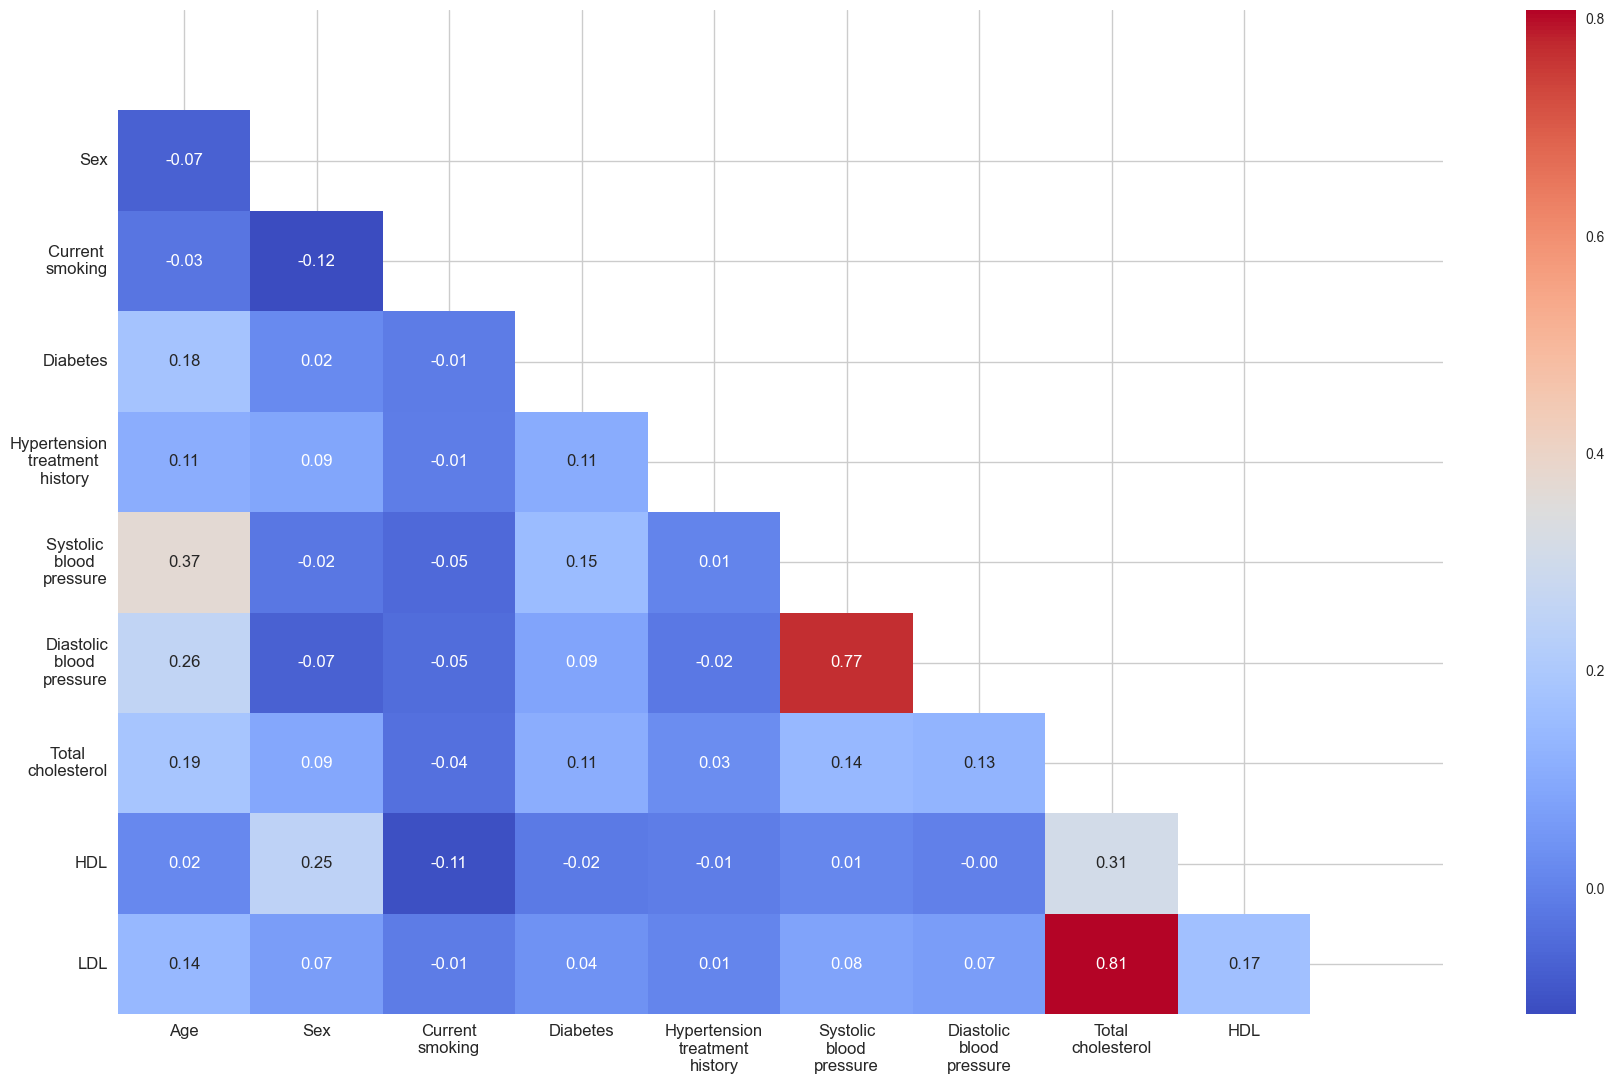

In [31]:
# Heatmap of features
heat_data = data.drop(columns= ['total_CVD_event'])
heat_map = heat_data.corr().round(3)
mask = np.triu(np.ones_like(heat_map, dtype=bool))
xlabels = ['Age','Sex','Current\nsmoking','Diabetes','Hypertension\ntreatment\nhistory','Systolic\nblood\npressure','Diastolic\nblood\npressure',
          'Total\ncholesterol','HDL','LDL']
ylabels = ['Age','Sex','Current \nsmoking','Diabetes','Hypertension\ntreatment  \nhistory    ','Systolic \nblood   \npressure',
           'Diastolic\nblood   \npressure','Total     \ncholesterol','HDL','LDL']
plt.figure(figsize=(18,11))
hmap = sns.heatmap(heat_map, mask = mask, annot = True, fmt='.2f', annot_kws={'size':12}, cmap='coolwarm')

# Changing label's font size
hmap.set_xticklabels(xlabels, rotation=0, fontsize=12)
hmap.set_yticklabels(ylabels, rotation=0, fontsize=12)

# Deleting label of column and row that delete by mask
xlabels = hmap.get_xticks()
ylabels = hmap.get_yticks()
new_xlabels = np.delete(xlabels,(len(heat_data.columns) - 1))
new_ylabels = np.delete(ylabels,0)
hmap.set_xticks(new_xlabels)
hmap.set_yticks(new_ylabels)

# Showing heatmap
plt.tight_layout()
# plt.savefig('Basic_correlation.jpg', dpi=600)
plt.show()

In [32]:
# Pre-processing data
train_data, x_train, x_test, y_train, y_test = ml_preprocessing_spliting(data,['age','sbp','dbp','tchol','hdl','ldl'])

Null values in each column:
sbp      34
dbp      34
tchol    64
hdl      64
ldl      63
dtype: int64
****************************************
Data size after droping cases with missing data: (9394, 11)
Number of cardiovascular events: 960
****************************************
Train data size before Smote: (7515, 10)
Train data size after Smote: (13472, 10)
****************************************
Test data size before Smote: (1879, 10)
Test data size after Smote: (3396, 10)
****************************************
Numerical features transformed via StandardScaler
****************************************
Final train data
        age  sex  smoking  diabetes  htn_treatment       sbp       dbp  \
0  1.936188    1        0       1.0              0  0.009704 -0.060111   
1 -1.616687    1        0       0.0              0 -0.186055 -0.365739   
2  1.047969    0        0       0.0              1  0.614922 -0.365739   
3 -1.109134    1        0       0.0              0 -0.453047 -0.365739   

In [33]:
# Pre-processing data
train_data_no_smote, x_train_no_smote, x_test_no_smote, y_train_no_smote, y_test_no_smote = ml_preprocessing_spliting_no_smote(
    data, ['age','sbp','dbp','tchol','hdl','ldl'])

Null values in each column:
Series([], dtype: int64)
****************************************
Data size after droping cases with missing data: (9394, 11)
Number of cardiovascular events: 960
****************************************
Numerical features transformed via StandardScaler
****************************************
Final train data
           age  sex  smoking  diabetes  htn_treatment       sbp       dbp  \
4726  2.084060    1        0       1.0              0  0.203096  0.084116   
1048 -1.331532    1        0       0.0              0  0.001291 -0.213902   
8786  1.230162    0        0       0.0              1  0.827007 -0.213902   
8880 -0.843590    1        0       0.0              0 -0.273948 -0.213902   
386   0.132293    1        0       0.0              0  0.184765  0.084116   

         tchol       hdl       ldl  total_CVD_event  
4726  0.895995  0.410083  0.837662                0  
1048 -0.985011 -1.295869 -0.263626                0  
8786 -2.230543 -2.028425 -1.232195 

## Logistic Regression

In [34]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression

# Tunning model
search_space = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Fiting GreadSearchCV for finding best model parameters
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= LogisticRegression(),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose= 1)

# Tunning model
# gs.fit(x_train_no_smote, y_train_no_smote)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).head())
# print('*'*40)

# Basic_logistic_no_smote_model = gs.best_estimator_

# Creating best model object according to the GridSearchCV results
Basic_logistic_no_smote_model = LogisticRegression( C= 1, penalty= 'l2', solver= 'liblinear', max_iter= 100)
Basic_logistic_no_smote_model.fit(x_train_no_smote, y_train_no_smote)

label_map = {'age':'Age', 'sex':'Sex', 'smoking':'Current smoking', 'diabetes':'Diabetes', 'htn_treatment':'History of hypertension treatment',
             'sbp':'Systolic blood pressure', 'dbp':'Diastolic blood pressure', 'tchol':'Total cholesterol', 'hdl':'HDL', 'ldl':'LDL'}

# Creating the formula of model
print('Patient cardiovascular risk = ', end='')
for i in range(len(Basic_logistic_no_smote_model.feature_names_in_)):
    print(f'({Basic_logistic_no_smote_model.coef_[0][i].round(5)} × {label_map.get(Basic_logistic_no_smote_model.feature_names_in_[i])}) ', end='')
    if i != len(Basic_logistic_no_smote_model.feature_names_in_) - 1:
        print('+ ', end='')

Patient cardiovascular risk = (0.3299 × Age) + (-0.36204 × Sex) + (0.33709 × Current smoking) + (0.8669 × Diabetes) + (0.2719 × History of hypertension treatment) + (0.32507 × Systolic blood pressure) + (-0.02571 × Diastolic blood pressure) + (0.2408 × Total cholesterol) + (-0.16691 × HDL) + (-0.06452 × LDL) 

AUC Score: 0.7179619832236821


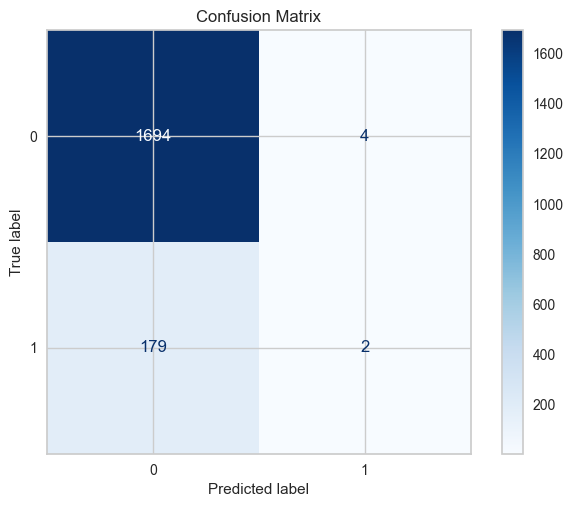


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1698
           1       0.33      0.01      0.02       181

    accuracy                           0.90      1879
   macro avg       0.62      0.50      0.49      1879
weighted avg       0.85      0.90      0.86      1879

******************************
f1_scores: [0.17572816 0.1758135  0.17589893 ... 0.01092896 0.01098901 0.        ]
precision: [0.09632783 0.09637913 0.09643047 ... 0.5        1.         1.        ]
recall: [1.         1.         1.         ... 0.00552486 0.00552486 0.        ]
****************************************
Accuracy: 0.9026077700904737
AUC: 0.7179619832236821
Sensitivity (recall): 0.011049723756906077
Precision: 0.3333333333333333
Specificity: 0.9976442873969376
f1-score: 0.0213903743315508
MCC: 0.045465692417043686
kappa: 0.01530350714917783
****************************************


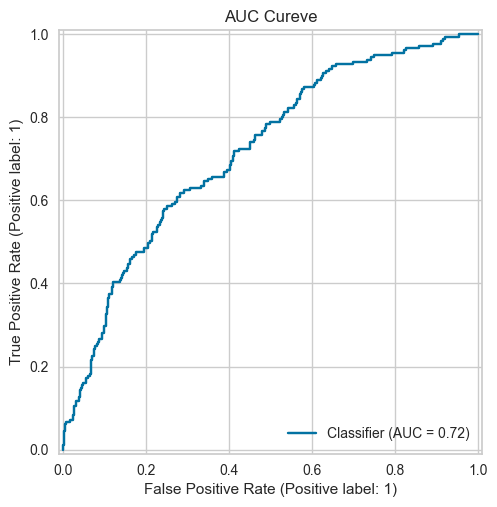

In [46]:
# Evaluating metrics of model
ml_metrics(Basic_logistic_no_smote_model, x_test_no_smote, y_test_no_smote)

## Catboost

In [47]:
# Import necessary libraries for modeling
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Defining searching space for tunning model
search_space = {
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [50, 200, 500],
    'depth': [4, 6, 8, 10]
    #'l2_leaf_reg': [1, 5, 10, 20]
}

# Fiting GreadSearchCV for finding best parameters
gs = GridSearchCV(estimator= CatBoostClassifier(verbose= 0),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose=2)

# Tunning model
# gs.fit(x_train, y_train)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).sort_values(by= ['rank_test_roc_auc']).head())

# Basic_catboost_model = gs.best_estimator_

# Creating best model object according to the GridSearchCV results
Basic_catboost_model = CatBoostClassifier(verbose=0, depth=10, iterations=500, learning_rate=0.1)
Basic_catboost_model.fit(x_train, y_train)

AUC Score: 0.6655939017842649


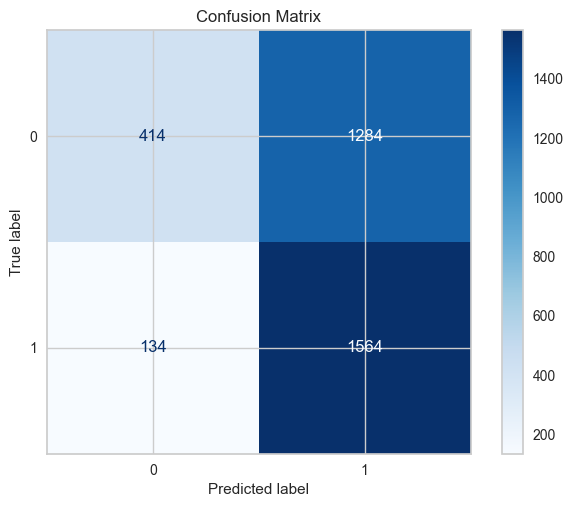


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.24      0.37      1698
           1       0.55      0.92      0.69      1698

    accuracy                           0.58      3396
   macro avg       0.65      0.58      0.53      3396
weighted avg       0.65      0.58      0.53      3396

******************************
f1_scores: [0.66666667 0.66679756 0.66692851 ... 0.00235294 0.00117716 0.        ]
precision: [0.5        0.50014728 0.50029464 ... 1.         1.         1.        ]
recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.17785630e-03
 5.88928151e-04 0.00000000e+00]
****************************************
Accuracy: 0.582449941107185
AUC: 0.6655939017842649
Sensitivity (recall): 0.9210836277974087
Precision: 0.5491573033707865
Specificity: 0.24381625441696114
f1-score: 0.6880774307083151
MCC: 0.22412884836824717
kappa: 0.1648998822143698
****************************************


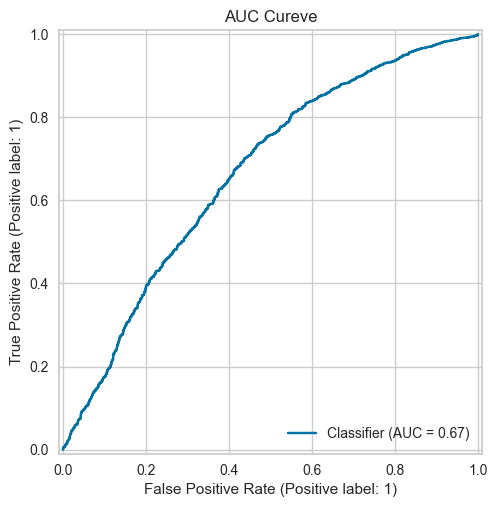

In [48]:
# Evaluating metrics of model
ml_metrics(Basic_catboost_model, x_test, y_test)

## Saving models information

In [35]:
save_model_information('Basic Logistic Regression model', Basic_logistic_no_smote_model,x_test_no_smote, y_test_no_smote)
save_model_information('Basic Catboost model', Basic_catboost_model, x_test, y_test)

# ASCVD database

In [36]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("*************/data/ASCVD_formula.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

   Sex  total_CVD_event  History of hypertension treatment  Current smoking  \
0    1                0                                  0                0   
1    1                0                                  1                0   
2    0                0                                  0                0   
3    1                0                                  0                1   
4    1                0                                  0                0   

   Diabetes  Age (ASCVD)  Age squared (ASCVD)  Total cholesterol (ASCVD)  \
0       0.0     3.912023            15.303924                   4.912655   
1       0.0     3.970292            15.763218                   4.804021   
2       0.0     4.158883            17.296309                   5.003946   
3       0.0     3.713572            13.790617                   5.023881   
4       0.0     3.583519            12.841608                   5.075174   

   HDL (ASCVD)  Systolic blood pressure (ASCVD)  \
0     3.850148   

,Sex,total_CVD_event,History of hypertension treatment,Current smoking,Diabetes,Age (ASCVD),Age squared (ASCVD),Total cholesterol (ASCVD),HDL (ASCVD),Systolic blood pressure (ASCVD),Interaction of Age and Total cholestrol (ASCVD),Interaction of Age and HDL (ASCVD),Interaction of Age and Systolic blood pressure (ASCVD),Interaction of Age and Current smoking (ASCVD)
0,1,0,0,0,0.0,3.912023,15.303924,4.912655,3.850148,4.787492,19.218419,15.061866,18.728778,0.000000
1,1,0,1,0,0.0,3.970292,15.763218,4.804021,3.784190,4.880276,19.073366,15.024338,19.376120,0.000000
2,0,0,0,0,0.0,4.158883,17.296309,5.003946,3.688879,4.706526,20.810828,15.341618,19.573890,0.000000
3,1,0,0,1,0.0,3.713572,13.790617,5.023881,3.583519,5.174267,18.656542,13.307656,19.215012,3.713572
4,1,0,0,0,0.0,3.583519,12.841608,5.075174,3.713572,4.700480,18.186981,13.307656,16.844260,0.000000
5,1,0,0,0,0.0,4.043051,16.346264,5.356586,4.007333,4.936867,21.656953,16.201854,19.960005,0.000000
6,0,0,0,0,0.0,3.784190,14.320091,5.463832,4.174387,4.700480,20.676176,15.796673,17.787509,0.000000
7,0,0,0,0,0.0,4.025352,16.203456,5.170484,3.891820,4.814888,20.813016,15.665945,19.381618,0.000000
8,1,1,0,0,0.0,3.784190,14.320091,5.278115,4.189655,5.075174,19.973387,15.854448,19.205420,0.000000
9,1,0,0,0,0.0,3.951244,15.612327,5.267858,4.234107,4.999460,20.814591,16.729987,19.754084,0.000000


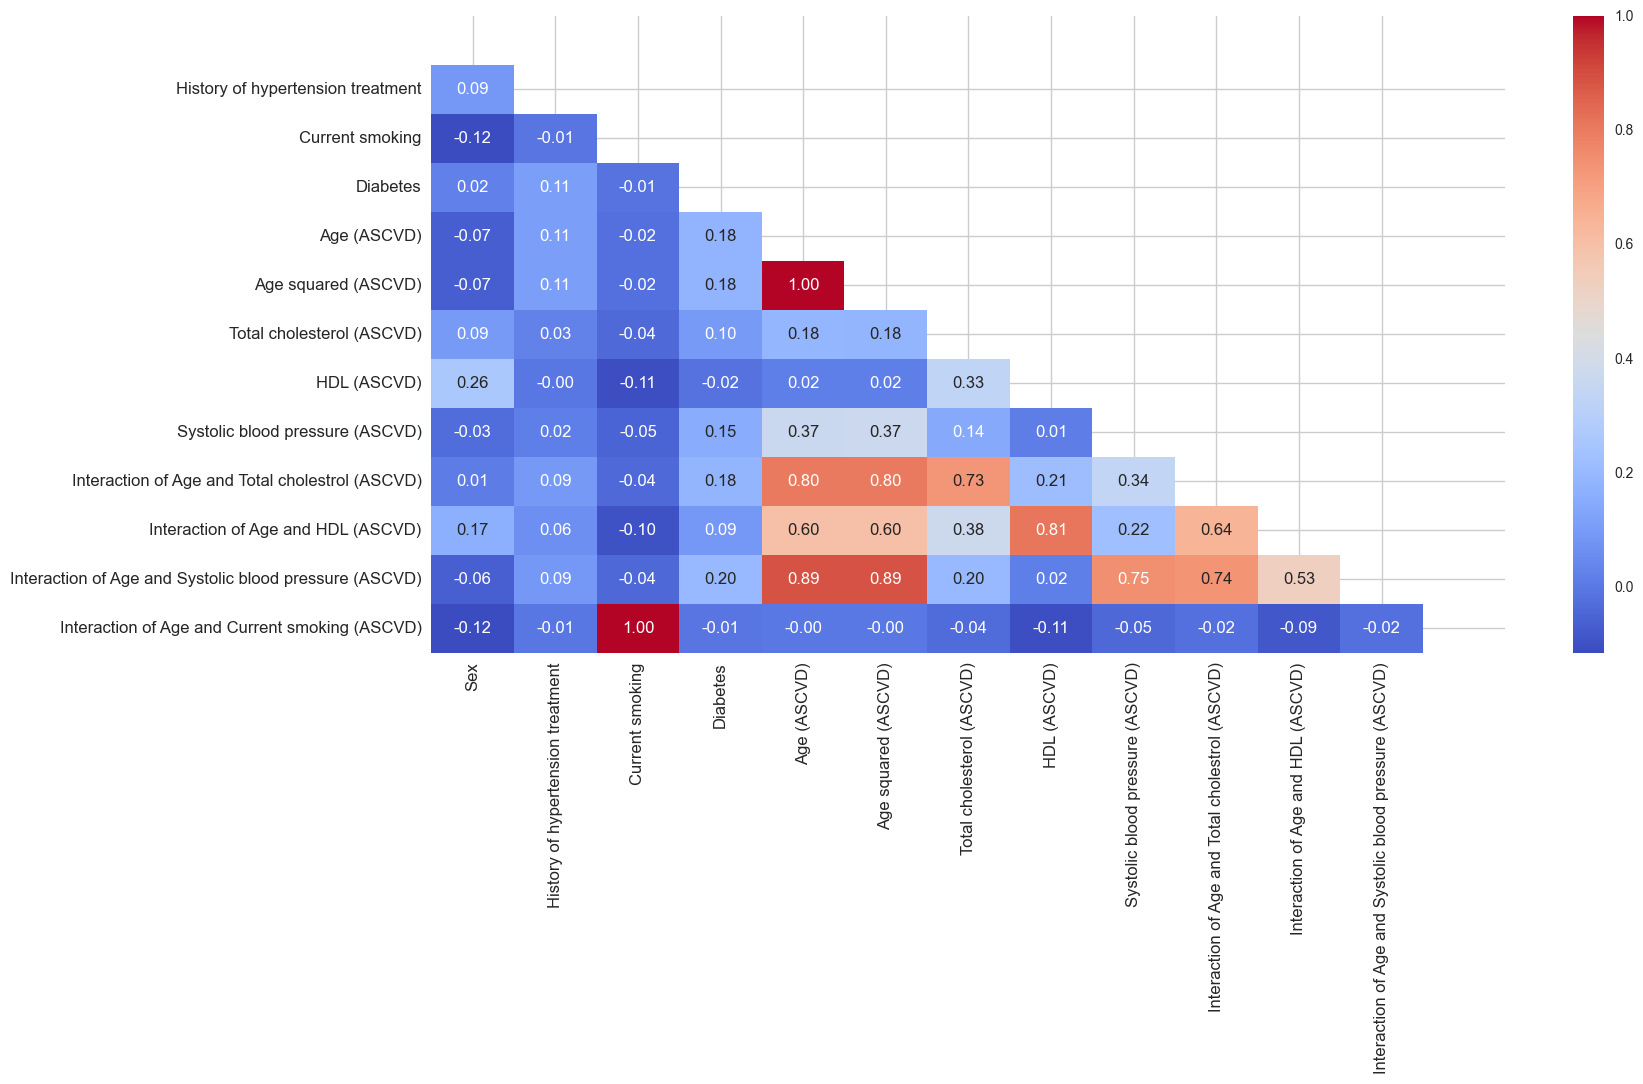

In [37]:
# Heatmap of features
draw_heatmap(data)

In [38]:
# Pre-processing data
train_data_no_smote, x_train_no_smote, x_test_no_smote, y_train_no_smote, y_test_no_smote = ml_preprocessing_spliting_no_smote(
    data,['Age (ASCVD)', 'Age squared (ASCVD)','Total cholesterol (ASCVD)', 'HDL (ASCVD)','Systolic blood pressure (ASCVD)',
        'Interaction of Age and Total cholestrol (ASCVD)','Interaction of Age and HDL (ASCVD)','Interaction of Age and Systolic blood pressure (ASCVD)',
       'Interaction of Age and Current smoking (ASCVD)'])

Null values in each column:
Total cholesterol (ASCVD)                                 64
HDL (ASCVD)                                               64
Systolic blood pressure (ASCVD)                           34
Interaction of Age and Total cholestrol (ASCVD)           64
Interaction of Age and HDL (ASCVD)                        64
Interaction of Age and Systolic blood pressure (ASCVD)    34
dtype: int64
****************************************
Data size after droping cases with missing data: (9395, 14)
Number of cardiovascular events: 961
****************************************
Numerical features transformed via StandardScaler
****************************************
Final train data
      Sex  History of hypertension treatment  Current smoking  Diabetes  \
1275    1                                  0                0       0.0   
3335    0                                  0                0       0.0   
4665    0                                  0                0       1.0   
2992  

## Logistic Regression

In [39]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression

# Tunning model
search_space = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Fiting GreadSearchCV for finding best model parameters
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= LogisticRegression(),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose= 1)

# Tunning model
# gs.fit(x_train_no_smote, y_train_no_smote)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).head())
# print('*'*40)

# ASCVD_logistic_no_smote_model = gs.best_estimator_

# Creating best model object according to the GridSearchCV results
ASCVD_logistic_no_smote_model = LogisticRegression( C= 1, penalty= 'l2', solver= 'liblinear', max_iter= 100)
ASCVD_logistic_no_smote_model.fit(x_train_no_smote, y_train_no_smote)

# showing the formula of model
print('Patient cardiovascular risk = ', end='')
for i in range(len(ASCVD_logistic_no_smote_model.feature_names_in_)):
    print(f'({ASCVD_logistic_no_smote_model.coef_[0][i].round(5)} × {ASCVD_logistic_no_smote_model.feature_names_in_[i]}) ', end='')
    if i != len(ASCVD_logistic_no_smote_model.feature_names_in_) - 1:
        print('+ ', end='')

Patient cardiovascular risk = (-0.39728 × Sex) + (0.3219 × History of hypertension treatment) + (-0.53669 × Current smoking) + (0.91875 × Diabetes) + (0.84315 × Age (ASCVD)) + (-0.53344 × Age squared (ASCVD)) + (-0.0105 × Total cholesterol (ASCVD)) + (-0.22943 × HDL (ASCVD)) + (0.46385 × Systolic blood pressure (ASCVD)) + (0.22808 × Interaction of Age and Total cholestrol (ASCVD)) + (0.11606 × Interaction of Age and HDL (ASCVD)) + (-0.24311 × Interaction of Age and Systolic blood pressure (ASCVD)) + (0.35731 × Interaction of Age and Current smoking (ASCVD)) 

AUC Score: 0.699575266366777


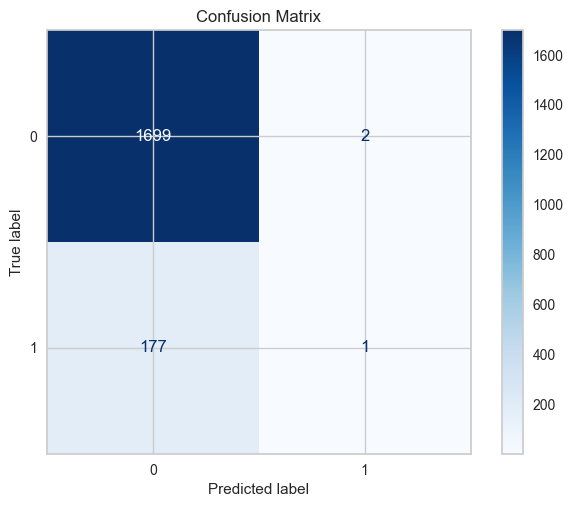


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1701
           1       0.33      0.01      0.01       178

    accuracy                           0.90      1879
   macro avg       0.62      0.50      0.48      1879
weighted avg       0.85      0.90      0.86      1879

******************************
f1_scores: [0.17306757 0.17315175 0.17323601 ... 0.         0.         0.        ]
precision: [0.09473124 0.09478168 0.09483218 ... 0.         0.         1.        ]
recall: [1. 1. 1. ... 0. 0. 0.]
****************************************
Accuracy: 0.9047365620010644
AUC: 0.699575266366777
Sensitivity (recall): 0.0056179775280898875
Precision: 0.3333333333333333
Specificity: 0.9988242210464433
f1-score: 0.011049723756906077
MCC: 0.03258240082339434
kappa: 0.007934377682276894
****************************************


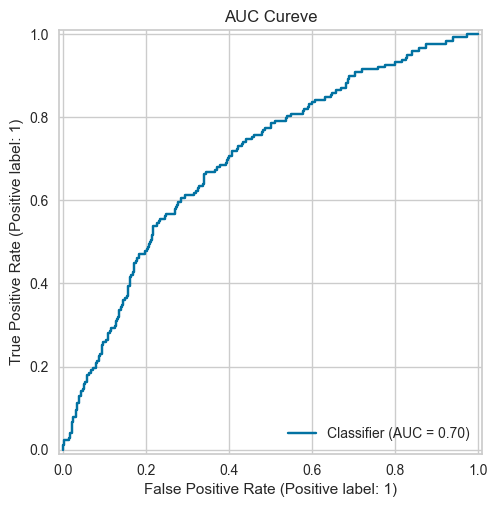

In [54]:
ml_metrics(ASCVD_logistic_no_smote_model, x_test_no_smote, y_test_no_smote)

## Save models information

In [40]:
save_model_information('ASCVD Logistic Regression model', ASCVD_logistic_no_smote_model,x_test_no_smote, y_test_no_smote)

# Framingham database

In [41]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("**************/data/Framingham_group_without_one_hot.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

    Age  Sex  Diabetes  Current smoking  Categorized LDL (Framingham)  \
0  50.0    1       0.0                0                           0.0   
1  53.0    1       0.0                0                           0.0   
2  64.0    0       0.0                0                           0.0   
3  41.0    1       0.0                1                           0.0   
4  36.0    1       0.0                0                           0.0   

   Categorized HDL (Framingham)  Categorized total cholesterol (Framingham)  \
0                           2.0                                         0.0   
1                           1.0                                         0.0   
2                           1.0                                         0.0   
3                           1.0                                         0.0   
4                           1.0                                         1.0   

   total_CVD_event  Age squared  Hypertension stage (Framingham)  
0                0 

,Age,Sex,Diabetes,Current smoking,Categorized LDL (Framingham),Categorized HDL (Framingham),Categorized total cholesterol (Framingham),total_CVD_event,Age squared,Hypertension stage (Framingham)
0,50.0,1,0.0,0,0.0,2.0,0.0,0,2500.0,1.0
1,53.0,1,0.0,0,0.0,1.0,0.0,0,2809.0,2.0
2,64.0,0,0.0,0,0.0,1.0,0.0,0,4096.0,1.0
3,41.0,1,0.0,1,0.0,1.0,0.0,0,1681.0,1.0
4,36.0,1,0.0,0,0.0,1.0,1.0,0,1296.0,1.0
5,57.0,1,0.0,0,2.0,3.0,2.0,0,3249.0,2.0
6,44.0,0,0.0,0,2.0,4.0,2.0,0,1936.0,0.0
7,56.0,0,0.0,0,0.0,2.0,1.0,0,3136.0,1.0
8,44.0,1,0.0,0,1.0,4.0,1.0,1,1936.0,3.0
9,52.0,1,0.0,0,1.0,4.0,1.0,0,2704.0,2.0


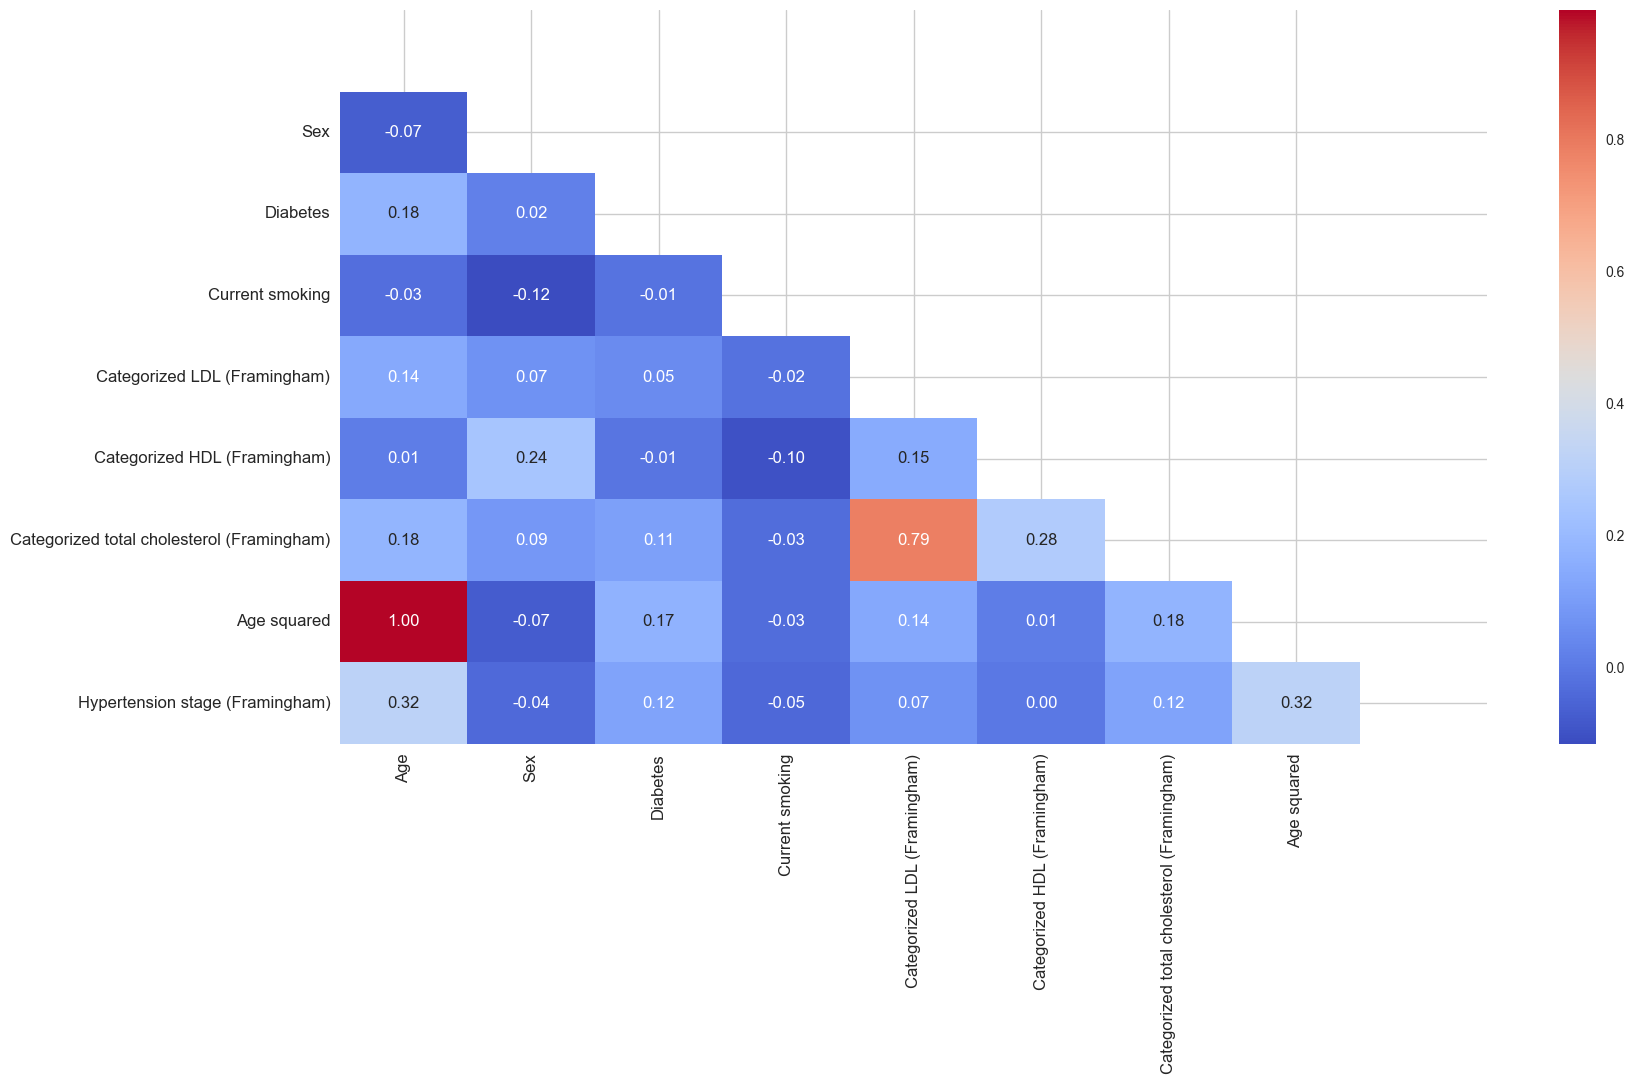

In [42]:
# Heatmap of features
draw_heatmap(data)

## Logistic Regression with Total cholesterol

In [43]:
# Deleting LDL from data
temp_data = data.drop(columns= ['Categorized LDL (Framingham)'])

# Pre-processing data
train_data_no_smote, x_train_no_smote, x_test_no_smote, y_train_no_smote, y_test_no_smote = ml_preprocessing_spliting_no_smote(
    temp_data,['Age','Age squared'], columns_rename_map= {
    'Hypertension stage (Framingham)_0.0':'Optimal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_1.0':'Normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_2.0':'High normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_3.0':'Stage 1 hyptertension (Framingham)',
    'Hypertension stage (Framingham)_4.0':'Stage 2 to 4 hyptertension (Framingham)',
    'Categorized HDL (Framingham)_0.0':'HDL ≤ 35 (Framingham)',
    'Categorized HDL (Framingham)_1.0':'HDL 35-45 (Framingham)',
    'Categorized HDL (Framingham)_2.0':'HDL 45-50 (Framingham)',
    'Categorized HDL (Framingham)_3.0':'HDL 50-60 (Framingham)',
    'Categorized HDL (Framingham)_4.0':'HDL ≥ 60(Framingham)',
    'Categorized total cholesterol (Framingham)_0.0':'Total cholesterol ≤ 160 (Framingham)',
    'Categorized total cholesterol (Framingham)_1.0':'Total cholesterol 160-200 (Framingham)',
    'Categorized total cholesterol (Framingham)_2.0':'Total cholesterol 200-240 (Framingham)',
    'Categorized total cholesterol (Framingham)_3.0':'Total cholesterol 240-280 (Framingham)',
    'Categorized total cholesterol (Framingham)_4.0':'Total cholesterol ≥ 280 (Framingham)'
})

Null values in each column:
Categorized HDL (Framingham)                  64
Categorized total cholesterol (Framingham)    64
Hypertension stage (Framingham)               34
dtype: int64
****************************************
Data size after droping cases with missing data: (9395, 9)
Number of cardiovascular events: 961
****************************************
Numerical features transformed via StandardScaler
****************************************
List of one-hoted columns: ['Categorized HDL (Framingham)', 'Categorized total cholesterol (Framingham)', 'Hypertension stage (Framingham)']
******************************
Final train data
           Age  Sex  Diabetes  Current smoking  Categorized HDL (Framingham)  \
1275 -0.481477    1       0.0                0                           NaN   
3335 -1.209945    0       0.0                0                           NaN   
4665  0.611224    0       1.0                0                           NaN   
2992 -0.117244    1       1.0     

In [44]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression

# Tunning model
search_space = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Fiting GreadSearchCV for finding best model parameters
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= LogisticRegression(),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose= 1)

# Tunning model
# gs.fit(x_train_no_smote, y_train_no_smote)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).head())
# print('*'*40)

# Framingham_logistic_tchol_no_smote_model = gs.best_estimator_

# Creating best model object according to GridSearchCV results
Framingham_logistic_tchol_no_smote_model = LogisticRegression( C= 1, penalty= 'l2', solver= 'lbfgs', max_iter= 100)
Framingham_logistic_tchol_no_smote_model.fit(x_train_no_smote, y_train_no_smote)

# showing the formula of model
print('Patients risk = ', end='')
for i in range(len(Framingham_logistic_tchol_no_smote_model.feature_names_in_)):
    print(f'({Framingham_logistic_tchol_no_smote_model.coef_[0][i].round(5)} × {Framingham_logistic_tchol_no_smote_model.feature_names_in_[i]}) ', end='')
    if i != len(Framingham_logistic_tchol_no_smote_model.feature_names_in_) - 1:
        print('+ ', end='')

Patients risk = (1.54469 × Age) + (-0.34975 × Sex) + (0.97052 × Diabetes) + (0.33511 × Current smoking) + (-1.12587 × Age squared) + (0.0721 × HDL ≤ 35 (Framingham)) + (-0.09229 × HDL 35-45 (Framingham)) + (-0.39016 × HDL 45-50 (Framingham)) + (-0.21655 × HDL 50-60 (Framingham)) + (-0.39063 × HDL ≥ 60(Framingham)) + (-0.41493 × Total cholesterol ≤ 160 (Framingham)) + (-0.43687 × Total cholesterol 160-200 (Framingham)) + (-0.09517 × Total cholesterol 200-240 (Framingham)) + (-0.06623 × Total cholesterol 240-280 (Framingham)) + (-0.00434 × Total cholesterol ≥ 280 (Framingham)) + (-0.719 × Optimal hyptertension (Framingham)) + (-0.4818 × Normal hyptertension (Framingham)) + (-0.16629 × High normal hyptertension (Framingham)) + (0.09992 × Stage 1 hyptertension (Framingham)) + (0.24964 × Stage 2 to 4 hyptertension (Framingham)) 

AUC Score: 0.6967926996016884


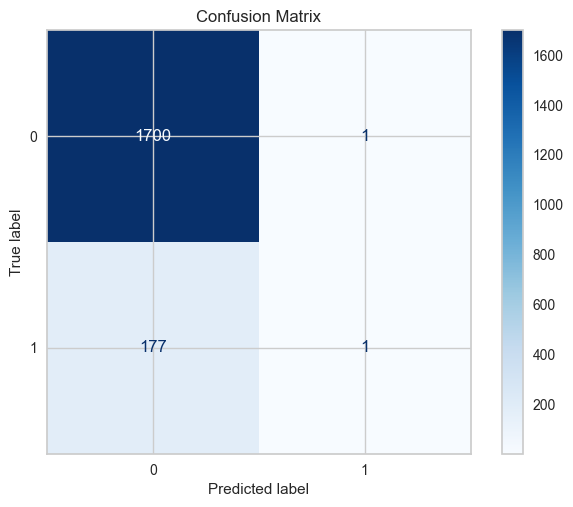


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1701
           1       0.50      0.01      0.01       178

    accuracy                           0.91      1879
   macro avg       0.70      0.50      0.48      1879
weighted avg       0.87      0.91      0.86      1879

******************************
f1_scores: [0.17306757 0.17315175 0.17323601 ... 0.01111111 0.         0.        ]
precision: [0.09473124 0.09478168 0.09483218 ... 0.5        0.         1.        ]
recall: [1.         1.         1.         ... 0.00561798 0.         0.        ]
****************************************
Accuracy: 0.905268759978712
AUC: 0.6967926996016884
Sensitivity (recall): 0.0056179775280898875
Precision: 0.5
Specificity: 0.9994121105232217
f1-score: 0.01111111111111111
MCC: 0.04517421466121698
kappa: 0.009024971259940506
****************************************


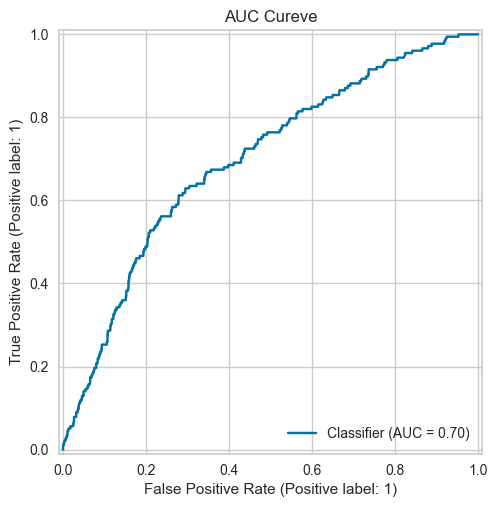

In [60]:
# Evaluating the metrics of model
ml_metrics(Framingham_logistic_tchol_no_smote_model, x_test_no_smote, y_test_no_smote)

## Logistic Regression with LDL

In [46]:
# Deleting total cholesterol from data
temp_data = data.drop(columns= ['Categorized total cholesterol (Framingham)'])

# pre-processing data
train_data_no_smote, x_train_no_smote, x_test_no_smote, y_train_no_smote, y_test_no_smote = ml_preprocessing_spliting_no_smote(
    temp_data,['Age','Age squared'], columns_rename_map= {
    'Hypertension stage (Framingham)_0.0':'Optimal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_1.0':'Normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_2.0':'High normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_3.0':'Stage 1 hyptertension (Framingham)',
    'Hypertension stage (Framingham)_4.0':'Stage 2 to 4 hyptertension (Framingham)',
    'Categorized LDL (Framingham)_0.0':'LDL ≤ 100 (Framingham)',
    'Categorized LDL (Framingham)_1.0':'LDL 100-130 (Framingham)',
    'Categorized LDL (Framingham)_2.0':'LDL 130-160 (Framingham)',
    'Categorized LDL (Framingham)_3.0':'LDL 160-190 (Framingham)',
    'Categorized LDL (Framingham)_4.0':'LDL ≥ 190 (Framingham)',
    'Categorized HDL (Framingham)_0.0':'HDL ≤ 35 (Framingham)',
    'Categorized HDL (Framingham)_1.0':'HDL 35-45 (Framingham)',
    'Categorized HDL (Framingham)_2.0':'HDL 45-50 (Framingham)',
    'Categorized HDL (Framingham)_3.0':'HDL 50-60 (Framingham)',
    'Categorized HDL (Framingham)_4.0':'HDL ≥ 60(Framingham)'
})

Null values in each column:
Categorized LDL (Framingham)       63
Categorized HDL (Framingham)       64
Hypertension stage (Framingham)    34
dtype: int64
****************************************
Data size after droping cases with missing data: (9395, 9)
Number of cardiovascular events: 960
****************************************
Numerical features transformed via StandardScaler
****************************************
List of one-hoted columns: ['Categorized LDL (Framingham)', 'Categorized HDL (Framingham)', 'Hypertension stage (Framingham)']
******************************
Final train data
           Age  Sex  Diabetes  Current smoking  Categorized LDL (Framingham)  \
1276  1.101570    1       0.0                0                           NaN   
3335 -1.212949    0       0.0                0                           NaN   
4665  0.614303    0       1.0                0                           NaN   
2992 -0.116598    1       1.0                0                           NaN   
2

In [47]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression

# Tunning model
search_space = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Fiting GreadSearchCV for finding best model parameters
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= LogisticRegression(),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose= 1)

# Tunning model
# gs.fit(x_train_no_smote, y_train_no_smote)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).head())
# print('*'*40)

# Framingham_logistic_ldl_no_smote_model = gs.best_estimator_

# Creating best model object according to GridSearchCV results
Framingham_logistic_ldl_no_smote_model = LogisticRegression(C= 1, penalty= 'l2', solver= 'liblinear', max_iter= 100)
Framingham_logistic_ldl_no_smote_model.fit(x_train_no_smote, y_train_no_smote)

# showing model formula
print('Patients risk = ', end='')
for i in range(len(Framingham_logistic_ldl_no_smote_model.feature_names_in_)):
    print(f'({Framingham_logistic_ldl_no_smote_model.coef_[0][i].round(5)} × {Framingham_logistic_ldl_no_smote_model.feature_names_in_[i]}) ', end='')
    if i != len(Framingham_logistic_ldl_no_smote_model.feature_names_in_) - 1:
        print('+ ', end='')

Patients risk = (1.4954 × Age) + (-0.35804 × Sex) + (0.99066 × Diabetes) + (0.34176 × Current smoking) + (-1.09075 × Age squared) + (-0.4166 × LDL ≤ 100 (Framingham)) + (-0.48059 × LDL 100-130 (Framingham)) + (-0.25272 × LDL 130-160 (Framingham)) + (-0.20417 × LDL 160-190 (Framingham)) + (0.05496 × LDL ≥ 190 (Framingham)) + (-0.03715 × HDL ≤ 35 (Framingham)) + (-0.16849 × HDL 35-45 (Framingham)) + (-0.45861 × HDL 45-50 (Framingham)) + (-0.25672 × HDL 50-60 (Framingham)) + (-0.37814 × HDL ≥ 60(Framingham)) + (-0.80587 × Optimal hyptertension (Framingham)) + (-0.55851 × Normal hyptertension (Framingham)) + (-0.21667 × High normal hyptertension (Framingham)) + (0.04176 × Stage 1 hyptertension (Framingham)) + (0.24018 × Stage 2 to 4 hyptertension (Framingham)) 

AUC Score: 0.6930085289213801


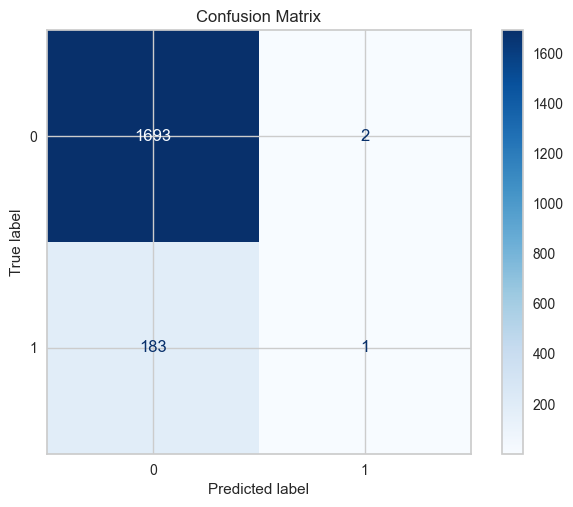


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1695
           1       0.33      0.01      0.01       184

    accuracy                           0.90      1879
   macro avg       0.62      0.50      0.48      1879
weighted avg       0.85      0.90      0.86      1879

******************************
f1_scores: [0.178381   0.17846751 0.1785541  ... 0.         0.         0.        ]
precision: [0.09792443 0.09797657 0.09802877 ... 0.         0.         1.        ]
recall: [1. 1. 1. ... 0. 0. 0.]
****************************************
Accuracy: 0.9015433741351783
AUC: 0.6930085289213801
Sensitivity (recall): 0.005434782608695652
Precision: 0.3333333333333333
Specificity: 0.9988200589970502
f1-score: 0.0106951871657754
MCC: 0.03167379603327002
kappa: 0.007577033651279486
****************************************


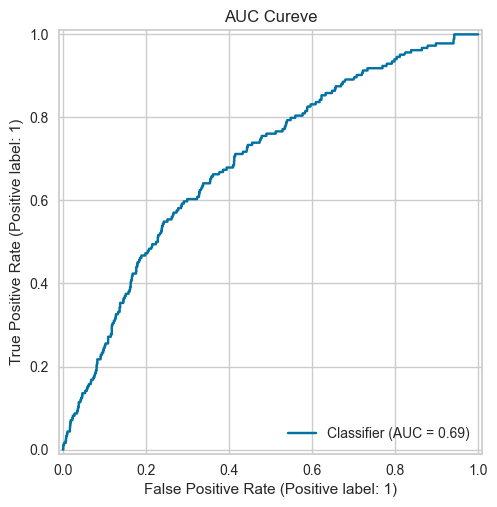

In [64]:
# Evaluating the metrics of model
ml_metrics(Framingham_logistic_ldl_no_smote_model, x_test_no_smote, y_test_no_smote)

## Save models information

In [48]:
save_model_information('Framingham Logistic Regression with Total cholesterol model', Framingham_logistic_tchol_no_smote_model,x_test_no_smote, y_test_no_smote)
save_model_information('Framingham Logistic Regression with LDL model', Framingham_logistic_ldl_no_smote_model,x_test_no_smote, y_test_no_smote)

# SCORE2 database

In [49]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("************/data/SCORE2_guideline.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

   Sex  total_CVD_event  Age (SCORE2)  Current smoking  \
0    1                0          -2.0                0   
1    1                0          -1.4                0   
2    0                0           0.8                0   
3    1                0          -3.8                1   
4    1                0          -4.8                0   

   Systolic blood pressure (SCORE2)  Diabetes  Total cholesterol (SCORE2)  \
0                           0.00000       0.0                   -2.483062   
1                           0.58335       0.0                   -2.845100   
2                          -0.46665       0.0                   -2.146884   
3                           2.83335       0.0                   -2.069304   
4                          -0.50000       0.0                   -1.862426   

   HDL (SCORE2)  Interaction of Age and Current smoking (SCORE2)  \
0     -0.169175                                             -0.0   
1     -0.324334                                     

,Sex,total_CVD_event,Age (SCORE2),Current smoking,Systolic blood pressure (SCORE2),Diabetes,Total cholesterol (SCORE2),HDL (SCORE2),Interaction of Age and Current smoking (SCORE2),Interaction of Age and Systolic blood pressure (SCORE2),Interaction of Age and Total cholestrol (SCORE2),Interaction of Age and HDL (SCORE2),Interaction of Age and Diabetes (SCORE2)
0,1,0,-2.0,0,0.00000,0.0,-2.483062,-0.169175,-0.0,-0.00000,4.966124,0.338350,-0.0
1,1,0,-1.4,0,0.58335,0.0,-2.845100,-0.324334,-0.0,-0.81669,3.983139,0.454068,-0.0
2,0,0,0.8,0,-0.46665,0.0,-2.146884,-0.531213,0.0,-0.37332,-1.717507,-0.424970,0.0
3,1,0,-3.8,1,2.83335,0.0,-2.069304,-0.738092,-3.8,-10.76673,7.863357,2.804748,-0.0
4,1,0,-4.8,0,-0.50000,0.0,-1.862426,-0.479493,-0.0,2.40000,8.939643,2.301567,-0.0
5,1,0,-0.6,0,0.96665,0.0,-0.517714,0.244582,-0.0,-0.57999,0.310628,-0.146749,-0.0
6,0,0,-3.2,0,-0.50000,0.0,0.102922,0.761779,-0.0,1.60000,-0.329351,-2.437693,-0.0
7,0,0,-0.8,0,0.16665,0.0,-1.448668,-0.065736,-0.0,-0.13332,1.158935,0.052589,-0.0
8,1,1,-3.2,0,2.00000,0.0,-0.931471,0.813499,-0.0,-6.40000,2.980709,-2.603196,-0.0
9,1,0,-1.6,0,1.41665,0.0,-0.983191,0.968658,-0.0,-2.26664,1.573106,-1.549853,-0.0


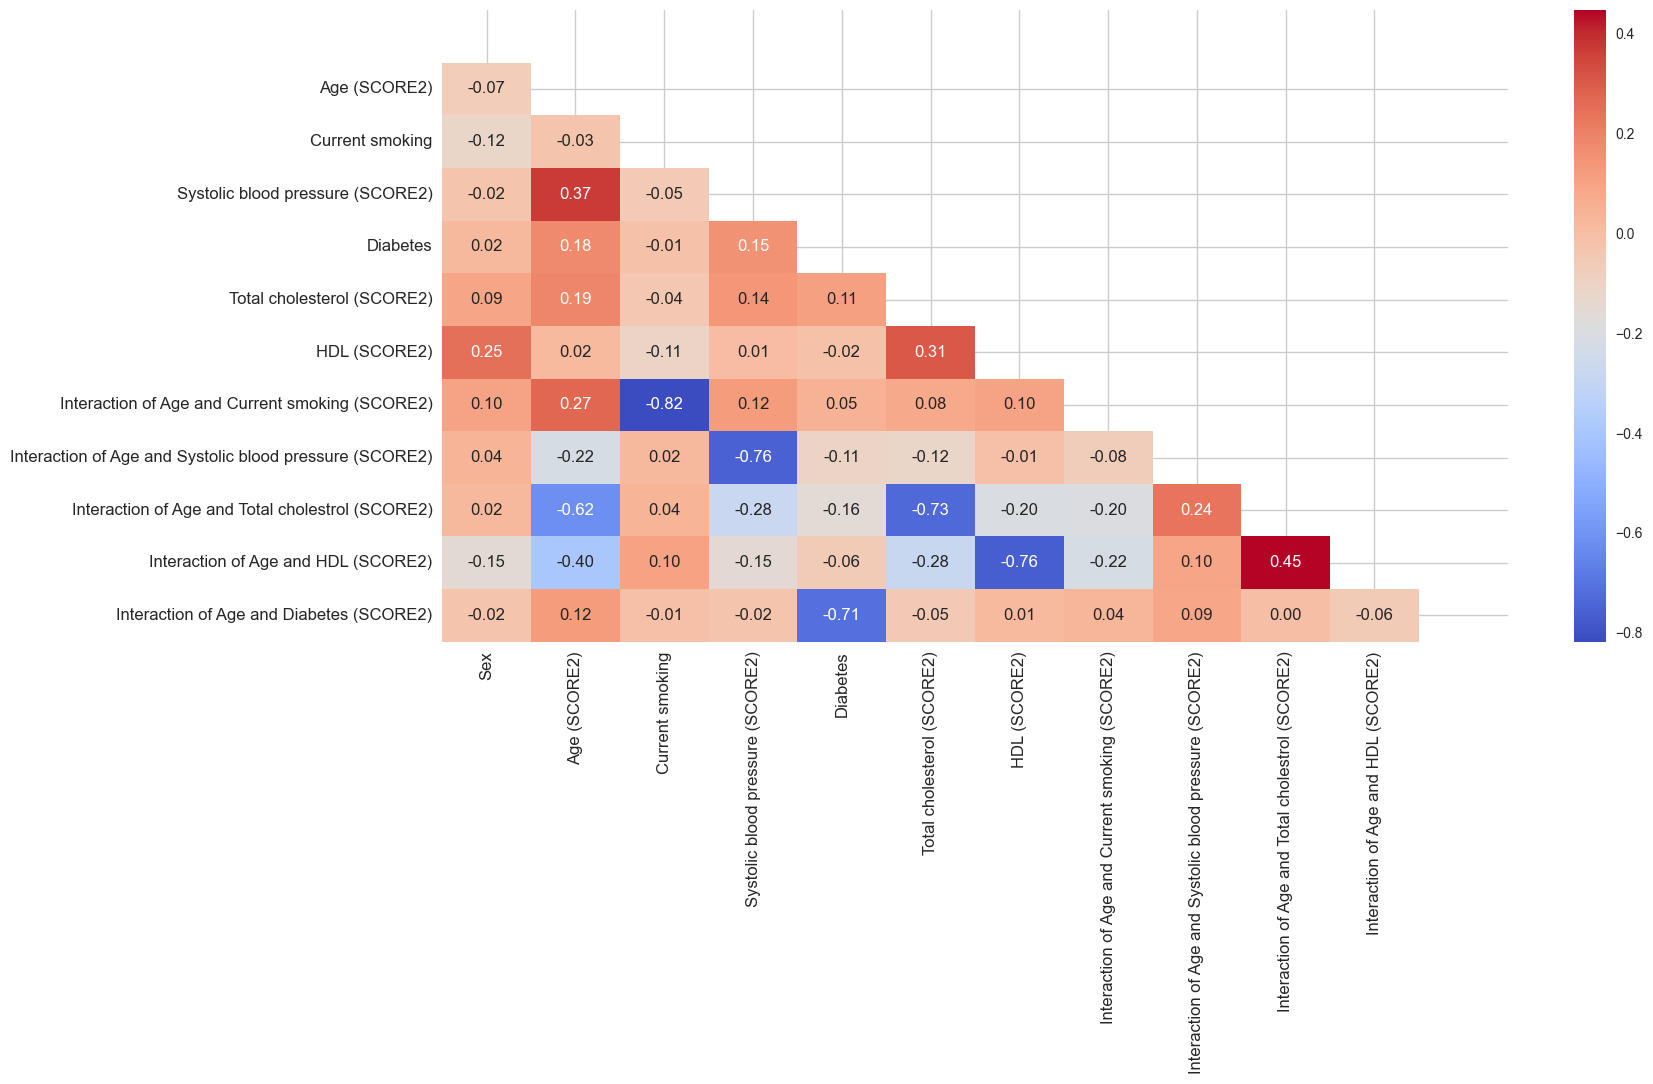

In [50]:
# Draw heatmap of data
draw_heatmap(data)

In [51]:
# Pre-processing data
train_data_no_smote, x_train_no_smote, x_test_no_smote, y_train_no_smote, y_test_no_smote = ml_preprocessing_spliting_no_smote(
    data,['Age (SCORE2)','Systolic blood pressure (SCORE2)',
        'Total cholesterol (SCORE2)', 'HDL (SCORE2)','Interaction of Age and Current smoking (SCORE2)',
       'Interaction of Age and Systolic blood pressure (SCORE2)','Interaction of Age and Total cholestrol (SCORE2)',
       'Interaction of Age and HDL (SCORE2)','Interaction of Age and Diabetes (SCORE2)'])

Null values in each column:
Systolic blood pressure (SCORE2)                           34
Total cholesterol (SCORE2)                                 64
HDL (SCORE2)                                               64
Interaction of Age and Systolic blood pressure (SCORE2)    34
Interaction of Age and Total cholestrol (SCORE2)           64
Interaction of Age and HDL (SCORE2)                        64
dtype: int64
****************************************
Data size after droping cases with missing data: (9395, 13)
Number of cardiovascular events: 961
****************************************
Numerical features transformed via StandardScaler
****************************************
Final train data
      Sex  Age (SCORE2)  Current smoking  Systolic blood pressure (SCORE2)  \
1275    1     -0.481477                0                          0.936594   
3335    0     -1.209945                0                         -0.633583   
4665    0      0.611224                0                         -

## Logistic Regression

In [52]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression

# Tunning model
search_space = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Fiting GreadSearchCV for finding best model parameters
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator= LogisticRegression(),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose= 1)

# Tunning model
# gs.fit(x_train_no_smote, y_train_no_smote)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).head())
# print('*'*40)

# SCORE2_logistic_no_smote_model = gs.best_estimator_

# Creating best model object according to GridSearchCV results
SCORE2_logistic_no_smote_model = LogisticRegression( C= 1, penalty= 'l1', solver= 'liblinear', max_iter= 500)
SCORE2_logistic_no_smote_model.fit(x_train_no_smote, y_train_no_smote)

# Showing the formula of model
print('Patient risk = ', end='')
for i in range(len(SCORE2_logistic_no_smote_model.feature_names_in_)):
    print(f'({SCORE2_logistic_no_smote_model.coef_[0][i].round(5)} × {SCORE2_logistic_no_smote_model.feature_names_in_[i]}) ', end='')
    if i != len(SCORE2_logistic_no_smote_model.feature_names_in_) - 1:
        print('+ ', end='')

Patient risk = (-0.36664 × Sex) + (0.43031 × Age (SCORE2)) + (0.3787 × Current smoking) + (0.21824 × Systolic blood pressure (SCORE2)) + (0.7714 × Diabetes) + (0.12253 × Total cholesterol (SCORE2)) + (-0.13707 × HDL (SCORE2)) + (0.03036 × Interaction of Age and Current smoking (SCORE2)) + (-0.17279 × Interaction of Age and Systolic blood pressure (SCORE2)) + (0.0 × Interaction of Age and Total cholestrol (SCORE2)) + (0.0 × Interaction of Age and HDL (SCORE2)) + (-0.09463 × Interaction of Age and Diabetes (SCORE2)) 

AUC Score: 0.6998229726069926


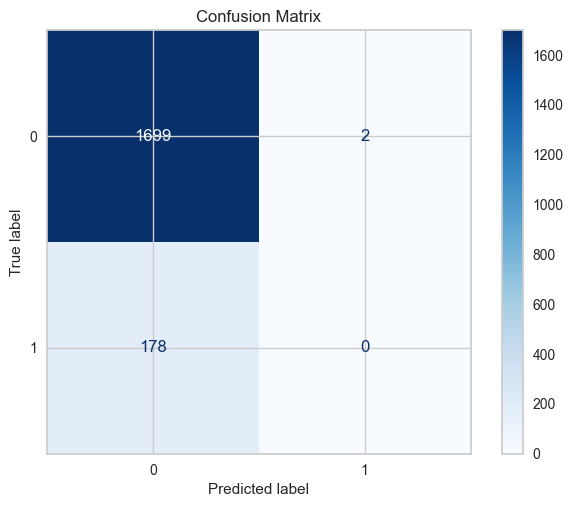


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1701
           1       0.00      0.00      0.00       178

    accuracy                           0.90      1879
   macro avg       0.45      0.50      0.47      1879
weighted avg       0.82      0.90      0.86      1879

******************************
f1_scores: [0.17306757 0.17315175 0.17323601 ... 0.         0.         0.        ]
precision: [0.09473124 0.09478168 0.09483218 ... 0.         0.         1.        ]
recall: [1. 1. 1. ... 0. 0. 0.]
****************************************
Accuracy: 0.9042043640234168
AUC: 0.6998229726069926
Sensitivity (recall): 0.0
Precision: 0.0
Specificity: 0.9988242210464433
f1-score: nan
MCC: -0.010559435600389524
kappa: -0.002109579624779201
****************************************


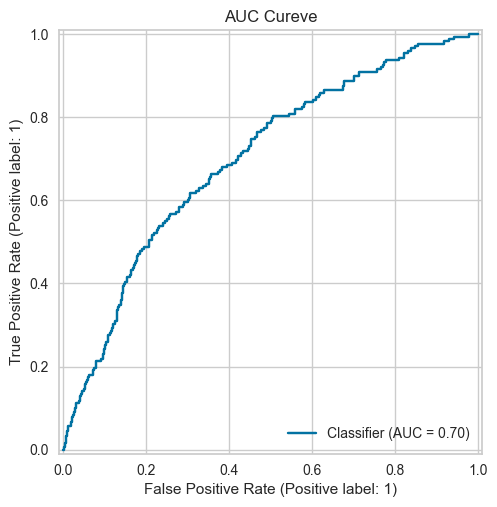

In [70]:
# Evaluating the metrics of model
ml_metrics(SCORE2_logistic_no_smote_model, x_test_no_smote, y_test_no_smote)

## Save models information

In [53]:
save_model_information('SCORE2 Logistic Regression model', SCORE2_logistic_no_smote_model,x_test_no_smote, y_test_no_smote)

# Comprehensive database

In [72]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("***********************/data/comprehensive_without_one_hot.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

    Age  Sex  Current smoking  Systolic blood pressure  \
0  50.0    1                0                  120.000   
1  53.0    1                0                  131.667   
2  64.0    0                0                  110.667   
3  41.0    1                1                  176.667   
4  36.0    1                0                  110.000   

   Diastolic blood pressure  History of hypertension treatment  Diabetes  \
0                    80.000                                  0       0.0   
1                    89.333                                  1       0.0   
2                    81.333                                  0       0.0   
3                    80.000                                  0       0.0   
4                    83.333                                  0       0.0   

   Total cholesterol   HDL   LDL  ...  Categorized LDL (Framingham)  \
0              136.0  47.0  77.4  ...                           0.0   
1              122.0  44.0  67.4  ...               

,Age,Sex,Current smoking,Systolic blood pressure,Diastolic blood pressure,History of hypertension treatment,Diabetes,Total cholesterol,HDL,LDL,...,Categorized LDL (Framingham),Age (SCORE2),Systolic blood pressure (SCORE2),Total cholesterol (SCORE2),HDL (SCORE2),Interaction of Age and Current smoking (SCORE2),Interaction of Age and Systolic blood pressure (SCORE2),Interaction of Age and Diabetes (SCORE2),Interaction of Age and Total cholestrol (SCORE2),Interaction of Age and HDL (SCORE2)
0,50.0,1,0,120.000,80.000,0,0.0,136.0,47.0,77.4,...,0.0,-2.0,0.00000,-2.483062,-0.169175,-0.0,-0.00000,-0.0,4.966124,0.338350
1,53.0,1,0,131.667,89.333,1,0.0,122.0,44.0,67.4,...,0.0,-1.4,0.58335,-2.845100,-0.324334,-0.0,-0.81669,-0.0,3.983139,0.454068
2,64.0,0,0,110.667,81.333,0,0.0,149.0,40.0,94.0,...,0.0,0.8,-0.46665,-2.146884,-0.531213,0.0,-0.37332,0.0,-1.717507,-0.424970
3,41.0,1,1,176.667,80.000,0,0.0,152.0,36.0,81.6,...,0.0,-3.8,2.83335,-2.069304,-0.738092,-3.8,-10.76673,-0.0,7.863357,2.804748
4,36.0,1,0,110.000,83.333,0,0.0,160.0,41.0,94.4,...,0.0,-4.8,-0.50000,-1.862426,-0.479493,-0.0,2.40000,-0.0,8.939643,2.301567
5,57.0,1,0,139.333,90.667,0,0.0,212.0,55.0,139.6,...,2.0,-0.6,0.96665,-0.517714,0.244582,-0.0,-0.57999,-0.0,0.310628,-0.146749
6,44.0,0,0,110.000,71.667,0,0.0,236.0,65.0,147.0,...,2.0,-3.2,-0.50000,0.102922,0.761779,-0.0,1.60000,-0.0,-0.329351,-2.437693
7,56.0,0,0,123.333,86.000,0,0.0,176.0,49.0,92.8,...,0.0,-0.8,0.16665,-1.448668,-0.065736,-0.0,-0.13332,-0.0,1.158935,0.052589
8,44.0,1,0,160.000,90.000,0,0.0,196.0,66.0,117.6,...,1.0,-3.2,2.00000,-0.931471,0.813499,-0.0,-6.40000,-0.0,2.980709,-2.603196
9,52.0,1,0,148.333,88.667,0,0.0,194.0,69.0,105.6,...,1.0,-1.6,1.41665,-0.983191,0.968658,-0.0,-2.26664,-0.0,1.573106,-1.549853


In [73]:
# Reorder the columns
data = data.loc[:,['Age', 'Sex', 'Current smoking', 'Systolic blood pressure','Diastolic blood pressure',
        'History of hypertension treatment','Diabetes', 'Total cholesterol', 'HDL', 'LDL','Age squared', 'Age (ASCVD)',
        'Age squared (ASCVD)','Systolic blood pressure (ASCVD)', 'Total cholesterol (ASCVD)','HDL (ASCVD)',
        'Interaction of Age and Total cholestrol (ASCVD)','Interaction of Age and HDL (ASCVD)','Interaction of Age and Systolic blood pressure (ASCVD)',
       'Interaction of Age and Current smoking (ASCVD)','Hypertension stage (Framingham)','Categorized total cholesterol (Framingham)',
       'Categorized HDL (Framingham)', 'Categorized LDL (Framingham)','Age (SCORE2)', 'Systolic blood pressure (SCORE2)','Total cholesterol (SCORE2)',
        'HDL (SCORE2)','Interaction of Age and Current smoking (SCORE2)','Interaction of Age and Systolic blood pressure (SCORE2)',
       'Interaction of Age and Diabetes (SCORE2)','Interaction of Age and Total cholestrol (SCORE2)','Interaction of Age and HDL (SCORE2)',
        'total_CVD_event']]

In [74]:
# Pre-processing data
train_data, x_train, x_test, y_train, y_test = ml_preprocessing_spliting(
    data,['Age','Systolic blood pressure','Diastolic blood pressure','Total cholesterol','HDL','LDL','Age squared',
       'Age (ASCVD)', 'Age squared (ASCVD)', 'Systolic blood pressure (ASCVD)','Total cholesterol (ASCVD)', 'HDL (ASCVD)',
       'Interaction of Age and Total cholestrol (ASCVD)','Interaction of Age and HDL (ASCVD)','Interaction of Age and Systolic blood pressure (ASCVD)',
       'Interaction of Age and Current smoking (ASCVD)','Age (SCORE2)', 'Systolic blood pressure (SCORE2)','Total cholesterol (SCORE2)',
        'HDL (SCORE2)','Interaction of Age and Current smoking (SCORE2)','Interaction of Age and Systolic blood pressure (SCORE2)',
        'Interaction of Age and Diabetes (SCORE2)','Interaction of Age and Total cholestrol (SCORE2)','Interaction of Age and HDL (SCORE2)'],
    one_hot= False)

Null values in each column:
Systolic blood pressure                                    34
Diastolic blood pressure                                   34
Total cholesterol                                          64
HDL                                                        64
LDL                                                        63
Systolic blood pressure (ASCVD)                            34
Total cholesterol (ASCVD)                                  64
HDL (ASCVD)                                                64
Interaction of Age and Total cholestrol (ASCVD)            64
Interaction of Age and HDL (ASCVD)                         64
Interaction of Age and Systolic blood pressure (ASCVD)     34
Hypertension stage (Framingham)                            34
Categorized total cholesterol (Framingham)                 64
Categorized HDL (Framingham)                               64
Categorized LDL (Framingham)                               63
Systolic blood pressure (SCORE2)          

## Pycaret

,Description,Value
0,Session id,2433
1,Target,total_CVD_event
2,Target type,Binary
3,Original data shape,"(13472, 34)"
4,Transformed data shape,"(13472, 34)"
5,Transformed train set shape,"(9430, 34)"
6,Transformed test set shape,"(4042, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9189,0.9626,0.8643,0.9703,0.9140,0.8377,0.8430,1.6590
rf,Random Forest Classifier,0.9157,0.9700,0.8895,0.9390,0.9134,0.8314,0.8328,0.5180
gbc,Gradient Boosting Classifier,0.8792,0.9445,0.8114,0.9387,0.8703,0.7584,0.7656,0.5410
knn,K Neighbors Classifier,0.8627,0.9251,0.8634,0.8626,0.8627,0.7253,0.7257,0.0270
dt,Decision Tree Classifier,0.8540,0.8540,0.8655,0.8464,0.8557,0.7080,0.7084,0.4640
ada,Ada Boost Classifier,0.8074,0.8895,0.7729,0.8306,0.8004,0.6148,0.6167,0.1250
lr,Logistic Regression,0.7159,0.7921,0.7249,0.7122,0.7184,0.4318,0.4320,0.0160
svm,SVM - Linear Kernel,0.7053,0.7684,0.6965,0.7112,0.7025,0.4106,0.4121,0.0210


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

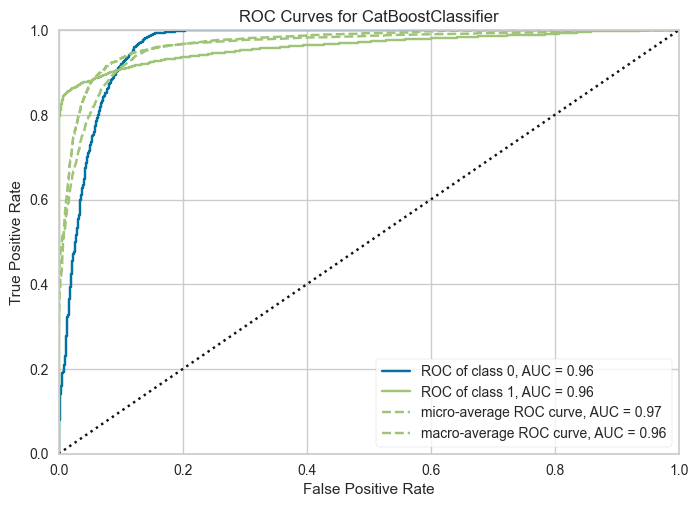

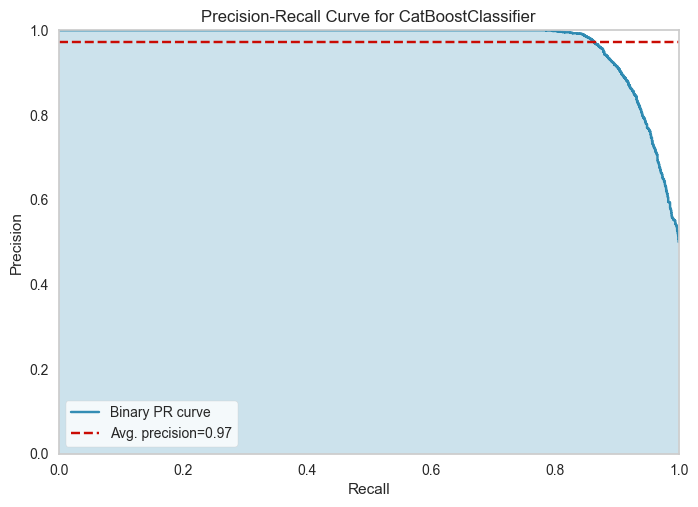

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9186,0.9616,0.8743,0.9593,0.9148,0.8372,0.8405


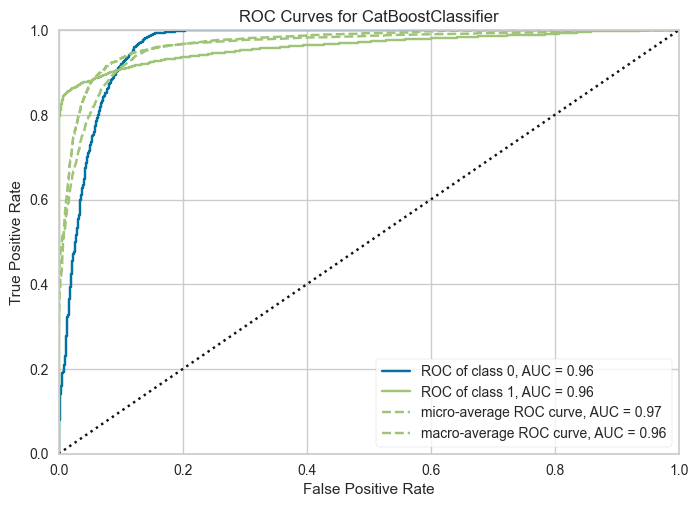

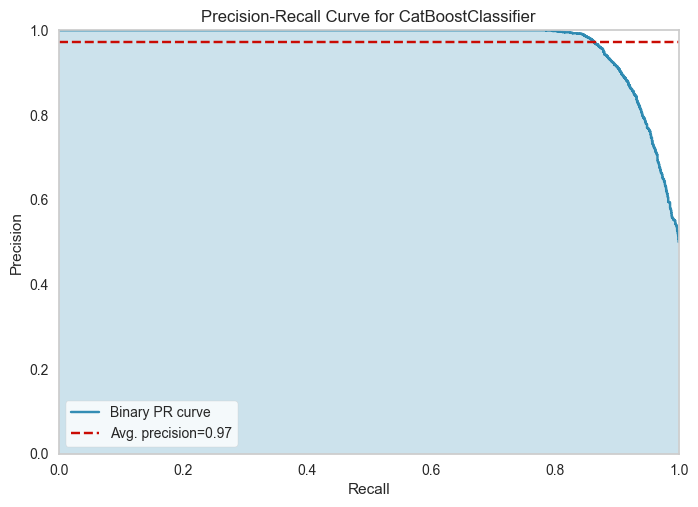

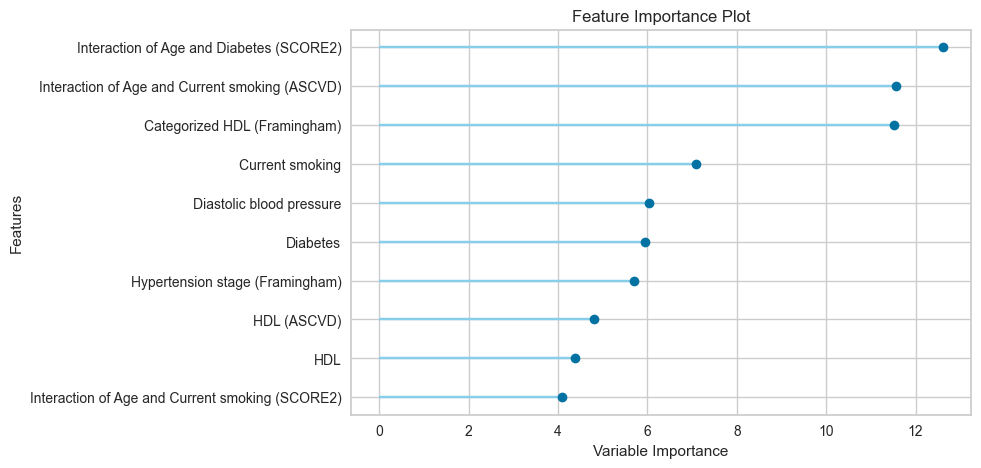

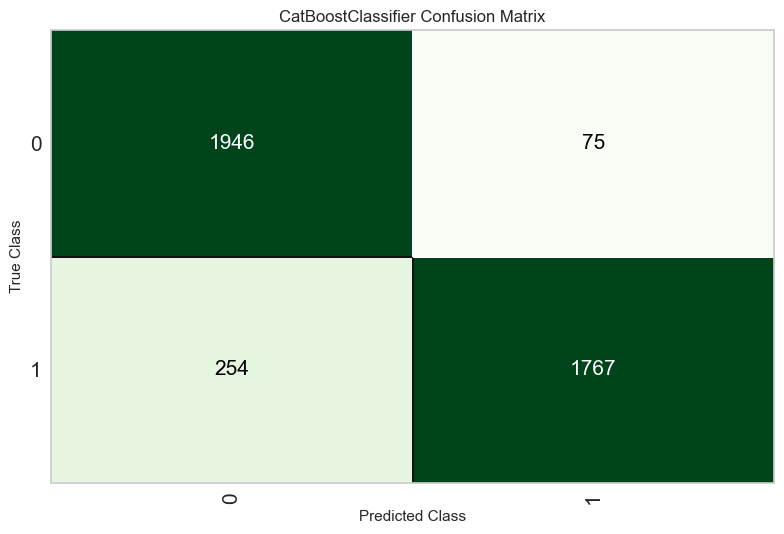

In [75]:
# Comparing the performance of different machine-learning model VS. logistic regression model via PyCaret framework 
from pycaret.classification import *
Comprehensive_pycaret_model = model_comparison(train_data)

## Catboost and feature importance

In [76]:
# Import necessary libraries for modeling
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Defining searching space for tunning model
search_space = {
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [50, 200, 500],
    'depth': [4, 6, 8, 10]
}

# Fiting GreadSearchCV for finding best parameters
gs = GridSearchCV(estimator= CatBoostClassifier(verbose= 0),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose=2)

# Tunning model
# gs.fit(x_train, y_train)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).sort_values(by= ['rank_test_roc_auc']).head())

# Comprehensive_catboost_model = gs.best_estimator_

# Creating best model object according to the GridSearchCV results
Comprehensive_catboost_model = CatBoostClassifier(verbose=0, depth= 10, iterations= 500, learning_rate= 0.2)
Comprehensive_catboost_model.fit(x_train, y_train)

AUC Score: 0.8935638962765036


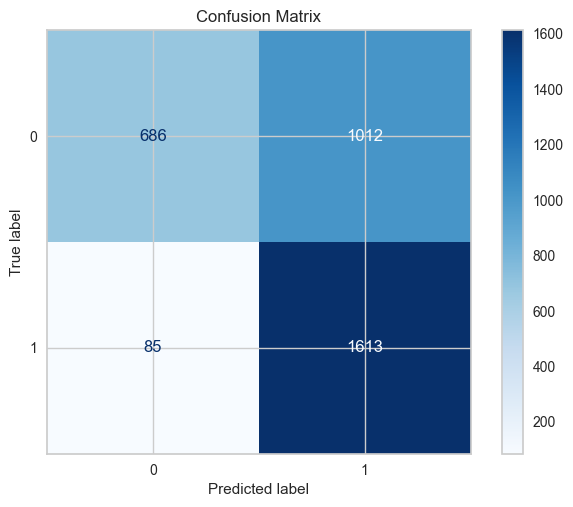


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.40      0.56      1698
           1       0.61      0.95      0.75      1698

    accuracy                           0.68      3396
   macro avg       0.75      0.68      0.65      3396
weighted avg       0.75      0.68      0.65      3396

******************************
f1_scores: [0.66666667 0.66679756 0.66692851 ... 0.00235294 0.00117716 0.        ]
precision: [0.5        0.50014728 0.50029464 ... 1.         1.         1.        ]
recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.17785630e-03
 5.88928151e-04 0.00000000e+00]
****************************************
Accuracy: 0.6769729093050648
AUC: 0.8935638962765036
Sensitivity (recall): 0.9499411071849234
Precision: 0.6144761904761905
Specificity: 0.4040047114252061
f1-score: 0.7462410363173722
MCC: 0.42245711522641294
kappa: 0.3539458186101295
****************************************


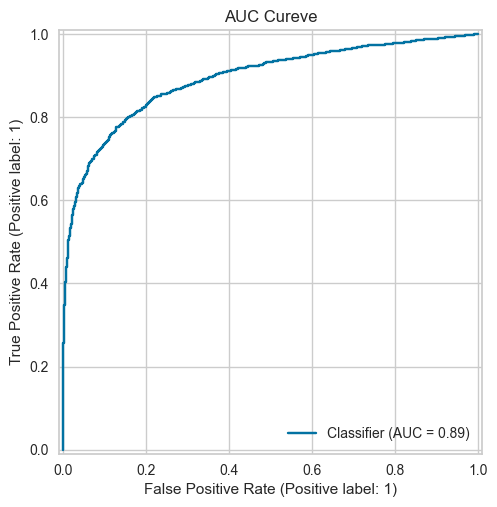

In [77]:
# Evaluating model metrics
ml_metrics(Comprehensive_catboost_model, x_test, y_test)

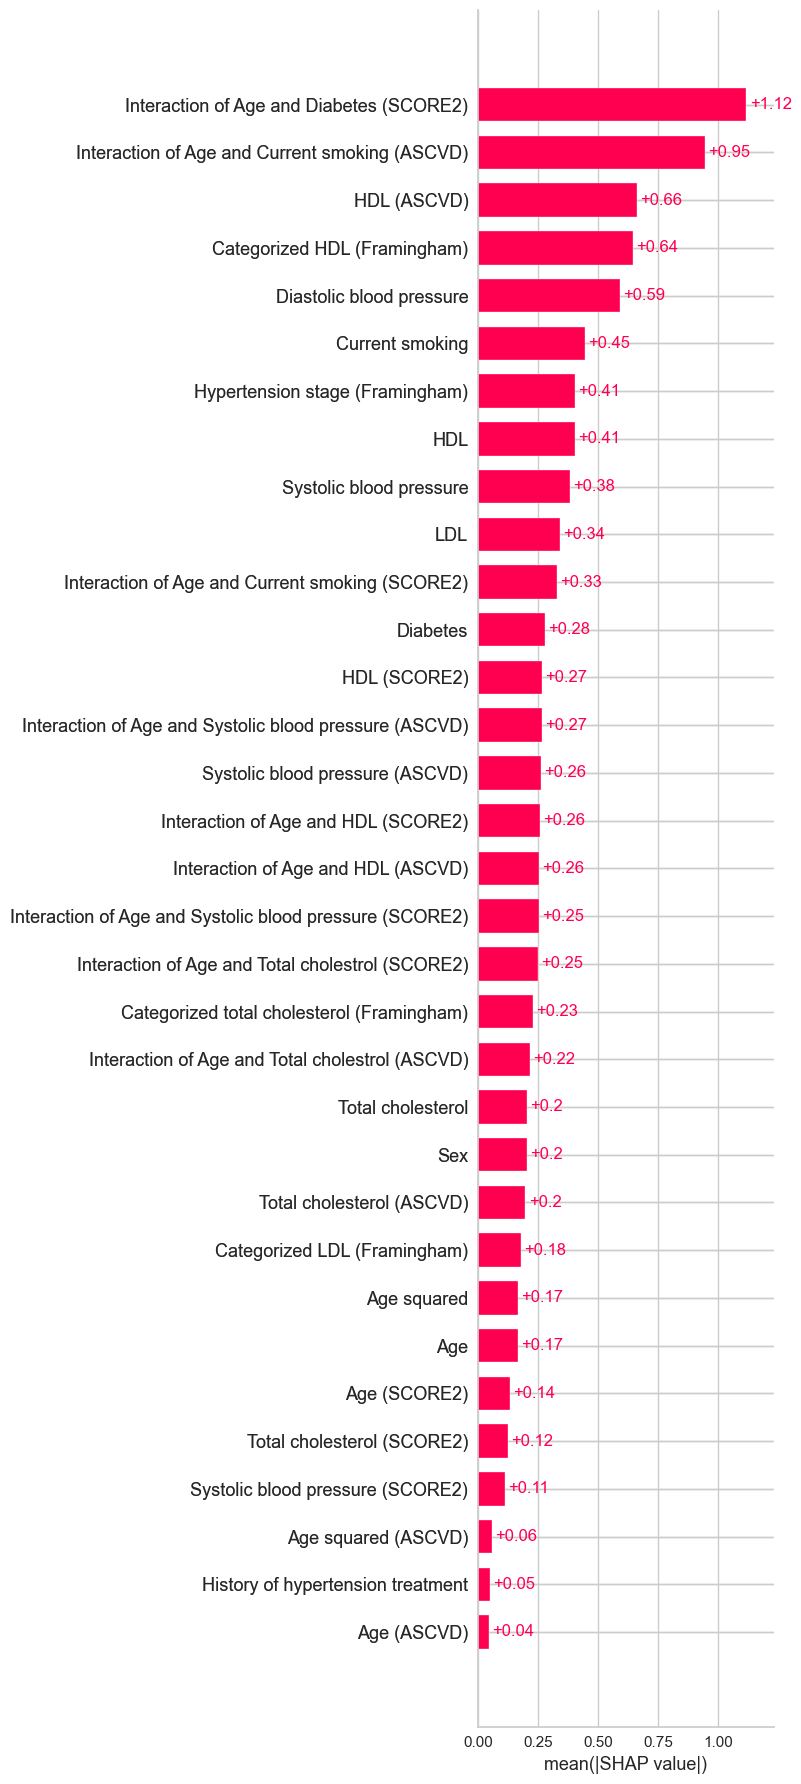

In [78]:
# Evaluating feature importance of model via SHAP library
import shap
explainer = shap.Explainer(Comprehensive_catboost_model)
shap_values = explainer(x_train)
plt.figure(figsize=(18,10))
if len(shap_values.shape) == 3:
    shap.plots.bar(shap_values[...,1], max_display= 35, show= False)
else:
    shap.plots.bar(shap_values, max_display= 35, show= False)
plt.tight_layout()
plt.savefig('Feature_importance_shap')
plt.show()

## Save models information

In [79]:
save_model_information('Comprehensive Catboost model', Comprehensive_catboost_model, x_test, y_test)

# Top features database

In [9]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Load the Excel file
data = pd.read_csv("***************/data/top_features_preprocessing1_without_one_hot_shap.csv", na_values=' ')
data.drop(columns='File.No', inplace=True)
print(data.head())
data.info()
data.columns
data.head(10)

   Age squared  Sex  Current smoking  Diabetes  \
0       2500.0    1                0       0.0   
1       2809.0    1                0       0.0   
2       4096.0    0                0       0.0   
3       1681.0    1                1       0.0   
4       1296.0    1                0       0.0   

   History of hypertension treatment  Hypertension stage (Framingham)  \
0                                  0                              1.0   
1                                  1                              2.0   
2                                  0                              1.0   
3                                  0                              1.0   
4                                  0                              1.0   

   Categorized total cholesterol (Framingham)  HDL (ASCVD)   LDL  \
0                                         0.0     3.850148  77.4   
1                                         0.0     3.784190  67.4   
2                                         0.0     3.6888

,Age squared,Sex,Current smoking,Diabetes,History of hypertension treatment,Hypertension stage (Framingham),Categorized total cholesterol (Framingham),HDL (ASCVD),LDL,Interaction of Age and Diabetes (SCORE2),Interaction of Age and Current smoking (ASCVD),Interaction of Age and Systolic blood pressure (ASCVD),Interaction of Age and Total cholestrol (SCORE2),Interaction of Age and HDL (SCORE2),total_CVD_event
0,2500.0,1,0,0.0,0,1.0,0.0,3.850148,77.4,-0.0,0.000000,18.728778,4.966124,0.338350,0
1,2809.0,1,0,0.0,1,2.0,0.0,3.784190,67.4,-0.0,0.000000,19.376120,3.983139,0.454068,0
2,4096.0,0,0,0.0,0,1.0,0.0,3.688879,94.0,0.0,0.000000,19.573890,-1.717507,-0.424970,0
3,1681.0,1,1,0.0,0,1.0,0.0,3.583519,81.6,-0.0,3.713572,19.215012,7.863357,2.804748,0
4,1296.0,1,0,0.0,0,1.0,1.0,3.713572,94.4,-0.0,0.000000,16.844260,8.939643,2.301567,0
5,3249.0,1,0,0.0,0,2.0,2.0,4.007333,139.6,-0.0,0.000000,19.960005,0.310628,-0.146749,0
6,1936.0,0,0,0.0,0,0.0,2.0,4.174387,147.0,-0.0,0.000000,17.787509,-0.329351,-2.437693,0
7,3136.0,0,0,0.0,0,1.0,1.0,3.891820,92.8,-0.0,0.000000,19.381618,1.158935,0.052589,0
8,1936.0,1,0,0.0,0,3.0,1.0,4.189655,117.6,-0.0,0.000000,19.205420,2.980709,-2.603196,1
9,2704.0,1,0,0.0,0,2.0,1.0,4.234107,105.6,-0.0,0.000000,19.754084,1.573106,-1.549853,0


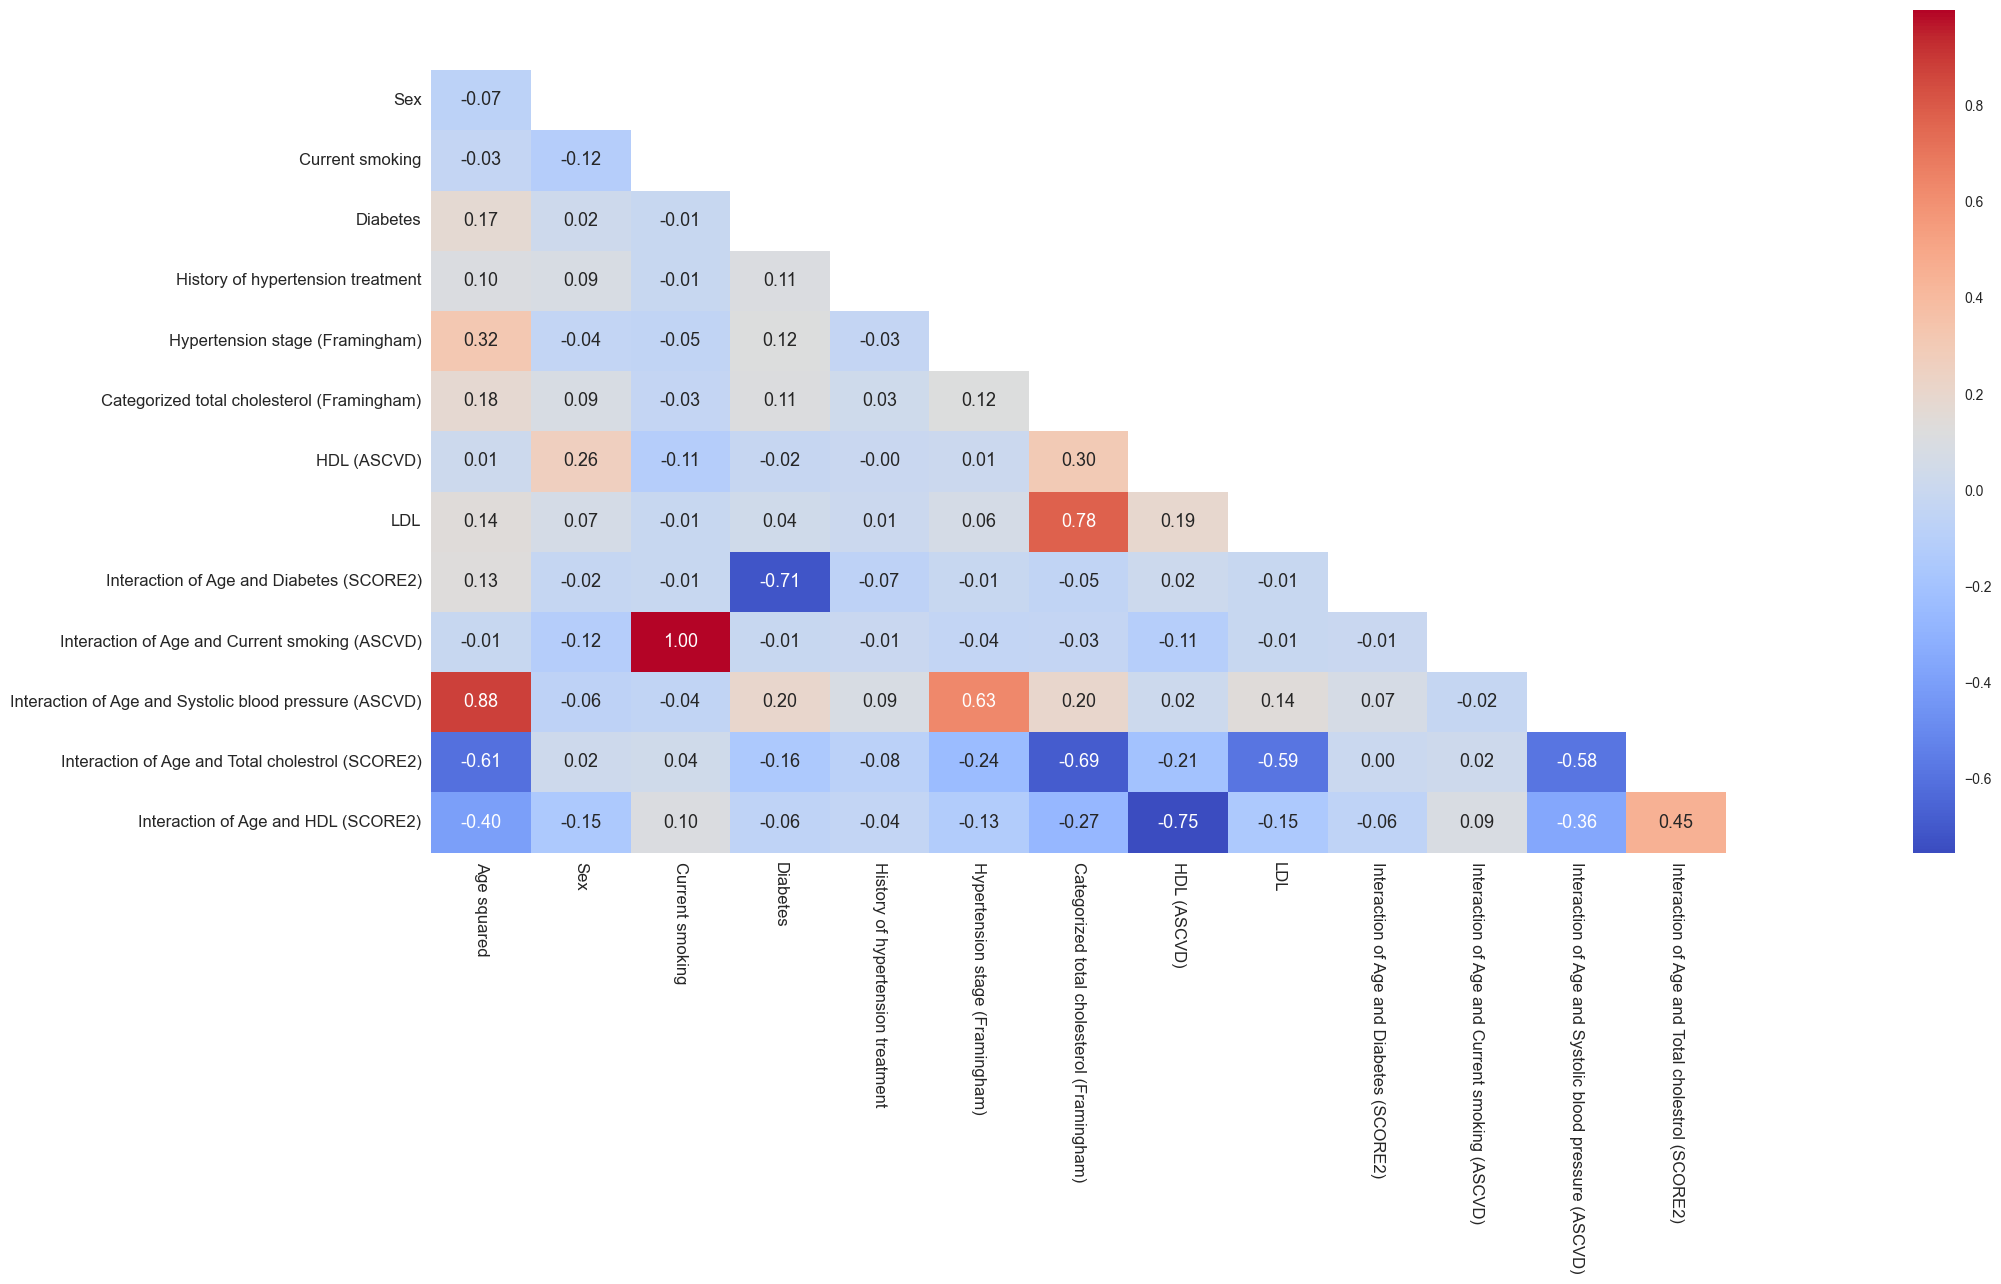

In [10]:
# Heatmap of features
heat_data = data.drop(columns= ['total_CVD_event']) 
heat_map = heat_data.corr().round(3)
mask = np.triu(np.ones_like(heat_map, dtype=bool))
plt.figure(figsize=(22,13))
hmap = sns.heatmap(heat_map, mask = mask, annot = True, fmt='.2f', annot_kws={'size':13}, cmap='coolwarm')

# Rotating and changing font size of labels
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=-90, fontsize=12)
hmap.set_yticklabels(hmap.get_yticklabels(), rotation=0, fontsize=12)

# Delet label of row and column that delete by mask
xlabels = hmap.get_xticks()
ylabels = hmap.get_yticks()
new_xlabels = np.delete(xlabels,(len(heat_data.columns) - 1))
new_ylabels = np.delete(ylabels,0)
hmap.set_xticks(new_xlabels)
hmap.set_yticks(new_ylabels)

# showing heatmap
plt.grid(False)
plt.tight_layout()
# plt.savefig('Figure1_top_features_before_delete.jpg', dpi= 600)
plt.show()

In [11]:
# Pre-processing data
train_data, x_train, x_test, y_train, y_test = ml_preprocessing_spliting(data,['Age squared','HDL (ASCVD)', 'LDL',
       'Interaction of Age and Diabetes (SCORE2)','Interaction of Age and Current smoking (ASCVD)',
       'Interaction of Age and Systolic blood pressure (ASCVD)','Interaction of Age and Total cholestrol (SCORE2)',
       'Interaction of Age and HDL (SCORE2)'], columns_rename_map= {
    'Hypertension stage (Framingham)_0.0':'Optimal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_1.0':'Normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_2.0':'High normal hyptertension (Framingham)',
    'Hypertension stage (Framingham)_3.0':'Stage 1 hyptertension (Framingham)',
    'Hypertension stage (Framingham)_4.0':'Stage 2 to 4 hyptertension (Framingham)',
    'Categorized total cholesterol (Framingham)_0.0':'Total cholesterol ≤ 160 (Framingham)',
    'Categorized total cholesterol (Framingham)_1.0':'Total cholesterol 160-200 (Framingham)',
    'Categorized total cholesterol (Framingham)_2.0':'Total cholesterol 200-240 (Framingham)',
    'Categorized total cholesterol (Framingham)_3.0':'Total cholesterol 240-280 (Framingham)',
    'Categorized total cholesterol (Framingham)_4.0':'Total cholesterol ≥ 280 (Framingham)'
})

Null values in each column:
Hypertension stage (Framingham)                           34
Categorized total cholesterol (Framingham)                64
HDL (ASCVD)                                               64
LDL                                                       63
Interaction of Age and Systolic blood pressure (ASCVD)    34
Interaction of Age and Total cholestrol (SCORE2)          64
Interaction of Age and HDL (SCORE2)                       64
dtype: int64
****************************************
Data size after droping cases with missing data: (9394, 15)
Number of cardiovascular events: 960
****************************************
Train data size before Smote: (7515, 14)
Train data size after Smote: (13472, 14)
****************************************
Test data size before Smote: (1879, 14)
Test data size after Smote: (3396, 14)
****************************************
Numerical features transformed via StandardScaler
****************************************
List of one-hoted c

## Catboost and SHAP plots

In [12]:
# Import necessary libraries for modeling
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Defining searching space for tunning model
search_space = {
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [50, 200, 500],
    'depth': [4, 6, 8, 10]
}

# Fiting GreadSearchCV for finding best parameters
gs = GridSearchCV(estimator= CatBoostClassifier(verbose= 0),
                  param_grid= search_space,
                  scoring= ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'matthews_corrcoef'],
                  refit= 'roc_auc',
                  cv= 3,
                  n_jobs= -1,
                  verbose=2)

# Tunning model
# gs.fit(x_train, y_train)
# print(f'Best parameters are: {gs.best_params_}')
# print('*'*40)
# print('Best results')
# print(pd.DataFrame(gs.cv_results_).sort_values(by= ['rank_test_roc_auc']).head())

# Top_features_catboost_model = gs.best_estimator_

# Creating best model object according to the GridSearchCV results
Top_features_catboost_model = CatBoostClassifier(verbose=0,depth= 10, iterations= 500, learning_rate= 0.2)
Top_features_catboost_model.fit(x_train, y_train)

AUC Score: 0.8389926623298247


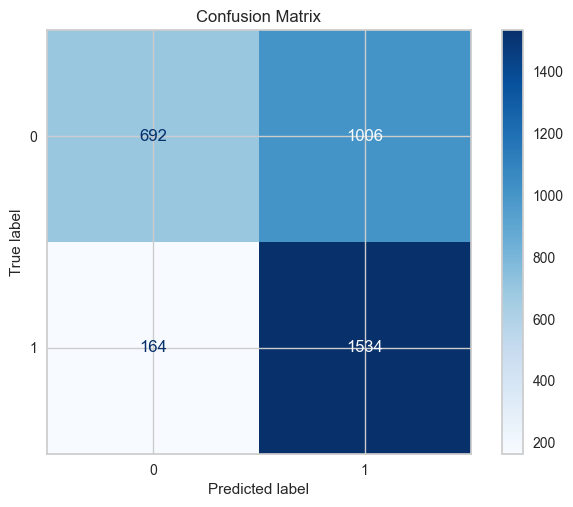


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.41      0.54      1698
           1       0.60      0.90      0.72      1698

    accuracy                           0.66      3396
   macro avg       0.71      0.66      0.63      3396
weighted avg       0.71      0.66      0.63      3396

******************************
f1_scores: [0.66666667 0.66679756 0.66692851 ... 0.00235294 0.00117716 0.        ]
precision: [0.5        0.50014728 0.50029464 ... 1.         1.         1.        ]
recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.17785630e-03
 5.88928151e-04 0.00000000e+00]
****************************************
Accuracy: 0.6554770318021201
AUC: 0.8389926623298247
Sensitivity (recall): 0.9034157832744405
Precision: 0.6039370078740157
Specificity: 0.4075382803297998
f1-score: 0.7239263803680981
MCC: 0.35808009649815997
kappa: 0.31095406360424027
****************************************


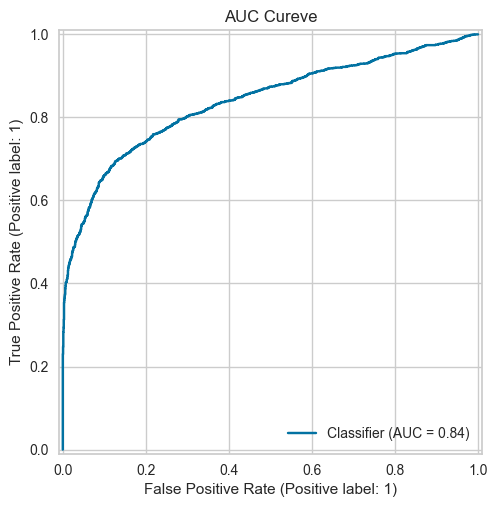

In [13]:
# Evaluating model metrics
ml_metrics(Top_features_catboost_model, x_test, y_test)

Evaluating of explaineble AI (SHAP)

In [14]:
# Import nessacery library
import shap

# Concatening x_test and y_test
y_test_df = pd.DataFrame(y_test, columns=['total_CVD_event'])
temp_test = x_test.join(y_test_df)

# creating SHAP explainer object
explainer = shap.TreeExplainer(Top_features_catboost_model)

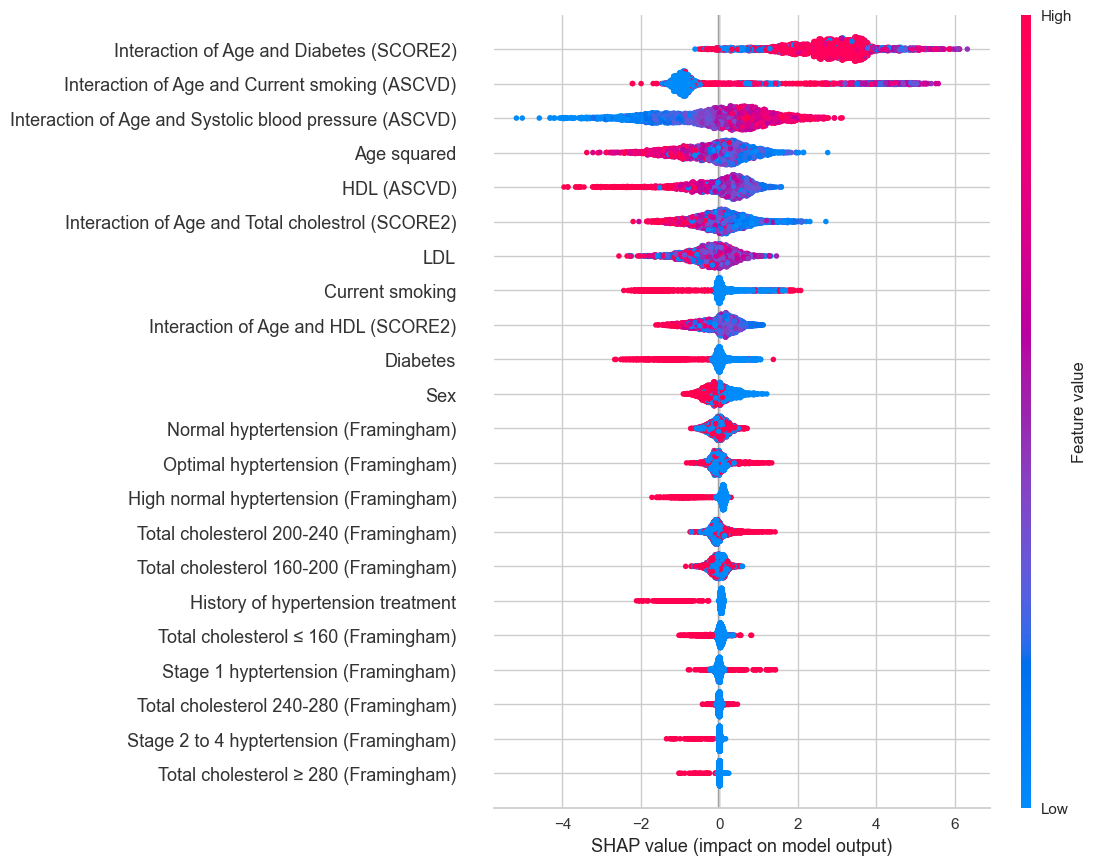

In [15]:
# draw SHAP summary plot for all patients
shap_values_all_patients = explainer(x_test)

shap.plots.beeswarm(shap_values_all_patients, max_display= 25, show= False)

# plt.savefig('Figure4_shap_all_patients.jpg', dpi= 600, bbox_inches='tight')
plt.show()

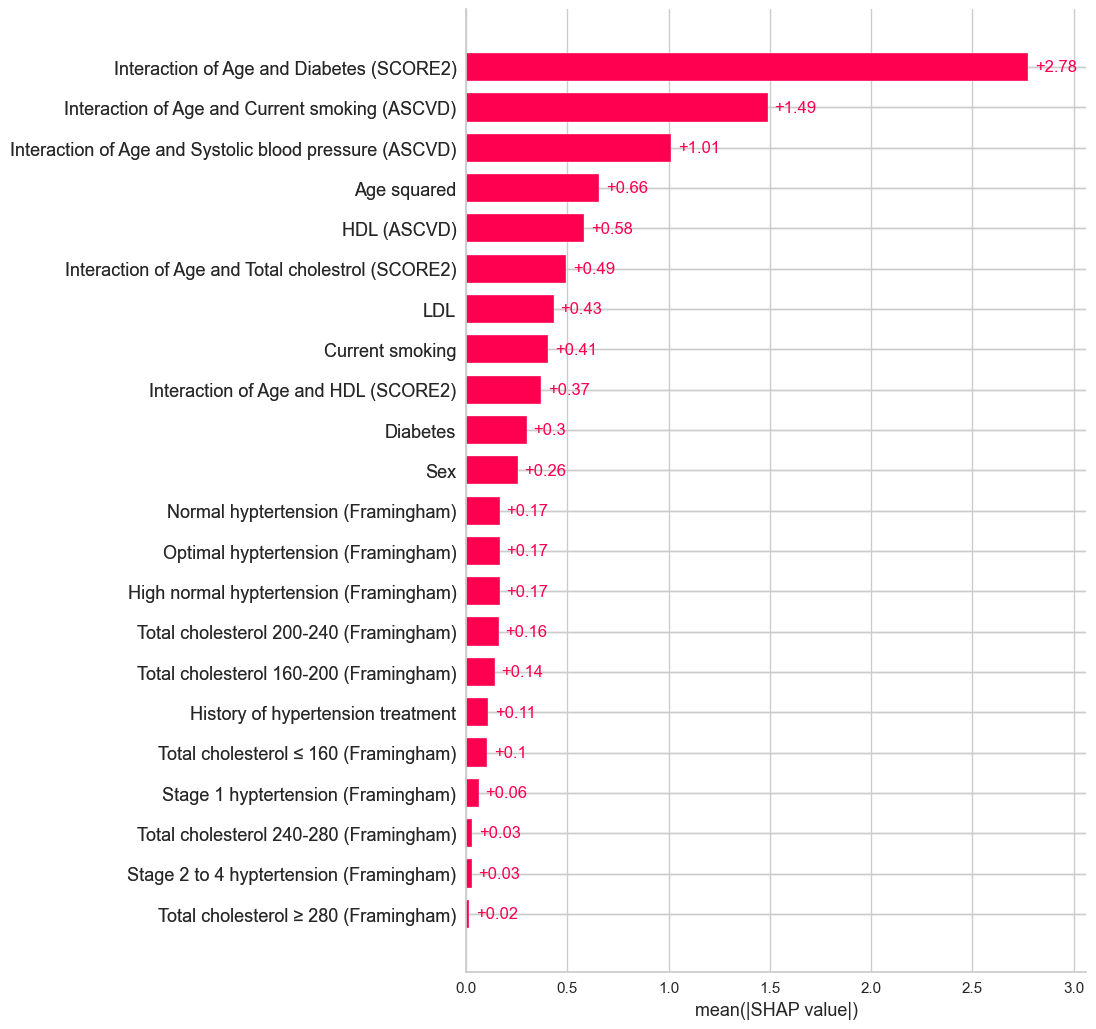

In [17]:
# Draw feature importance chart
shap.plots.bar(shap_values_all_patients, max_display= 25)

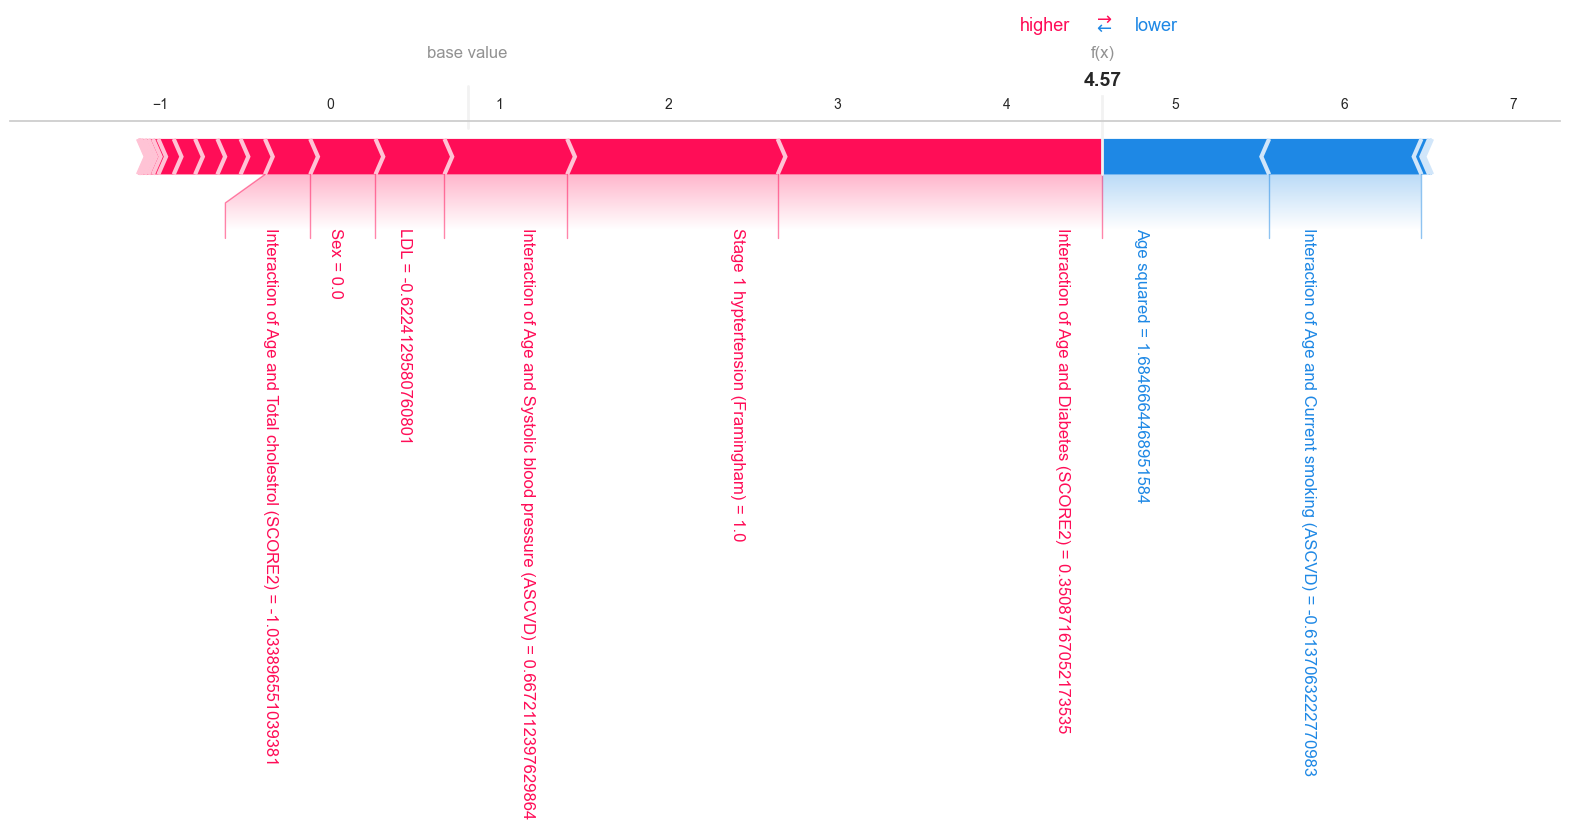

In [18]:
# Drawing SHAP force plot for a patient with cardiovascular event

# Importing nessecary libraries
import random

# Select a patient randomly
index_list = temp_test[temp_test['total_CVD_event'] == 1].index.tolist()
random_patient = random.choice(index_list)

# Draw chart
shap.plots.force(shap_values_all_patients[random_patient], show= False, matplotlib= True, text_rotation=-90)

plt.grid(False)
# plt.savefig('Figure6_shap_force_patient.jpg', dpi= 600, bbox_inches='tight')
plt.show()

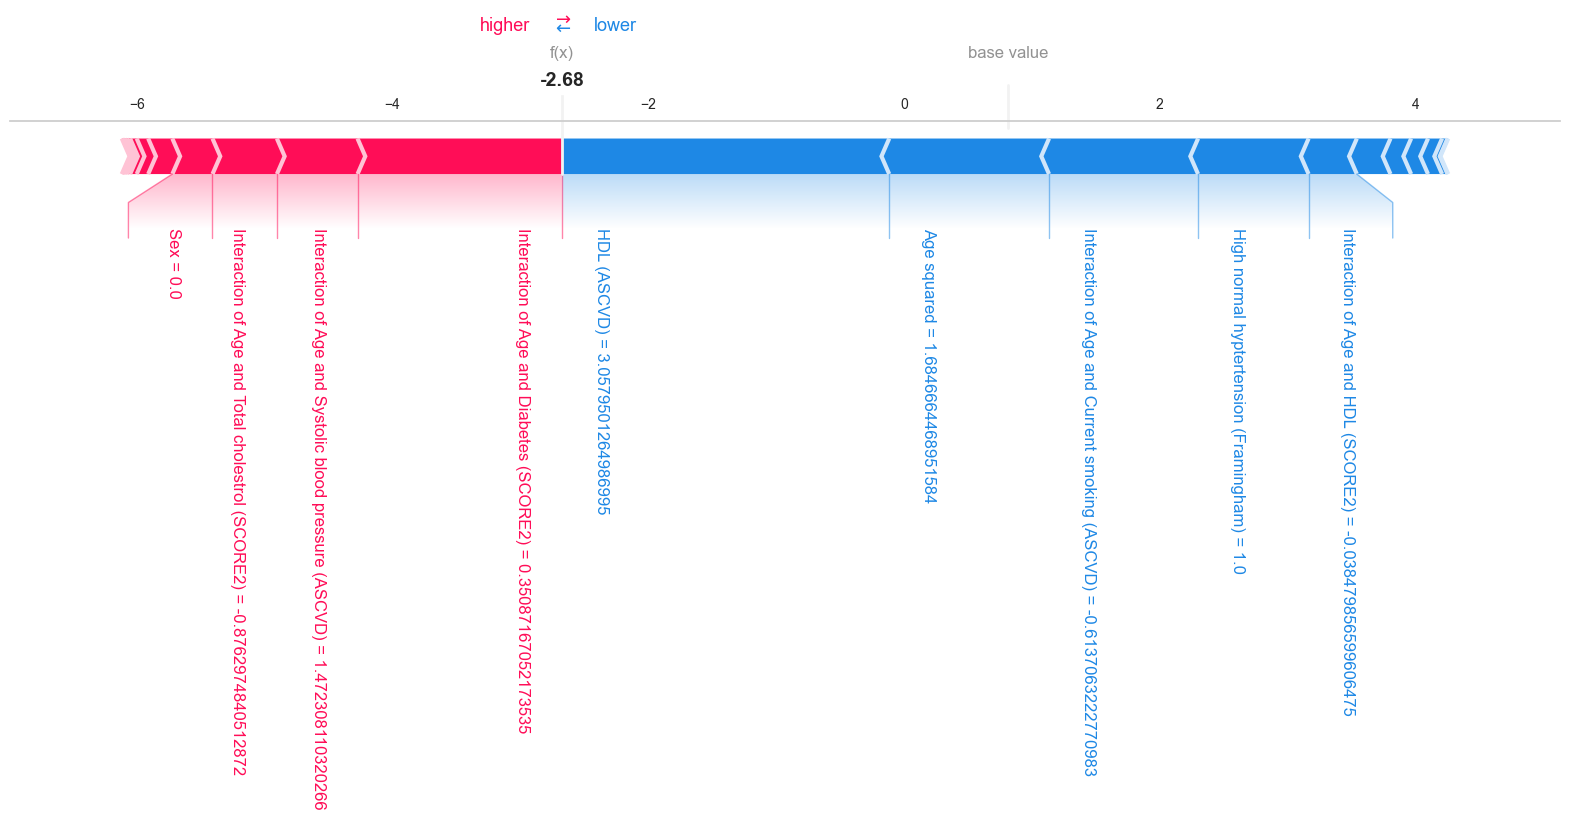

In [19]:
# Drawing SHAP force plot for a patient without cardiovascular event

# Importing nessecary libraries
import random

# Select a patient randomly
index_list = temp_test[temp_test['total_CVD_event'] == 0].index.tolist()
random_patient = random.choice(index_list)

# Draw chart
shap.plots.force(shap_values_all_patients[random_patient], show= False, matplotlib= True, text_rotation=-90)

plt.grid(False)
# plt.savefig('Figure7_shap_force_normal.jpg', dpi= 600, bbox_inches='tight')
plt.show()

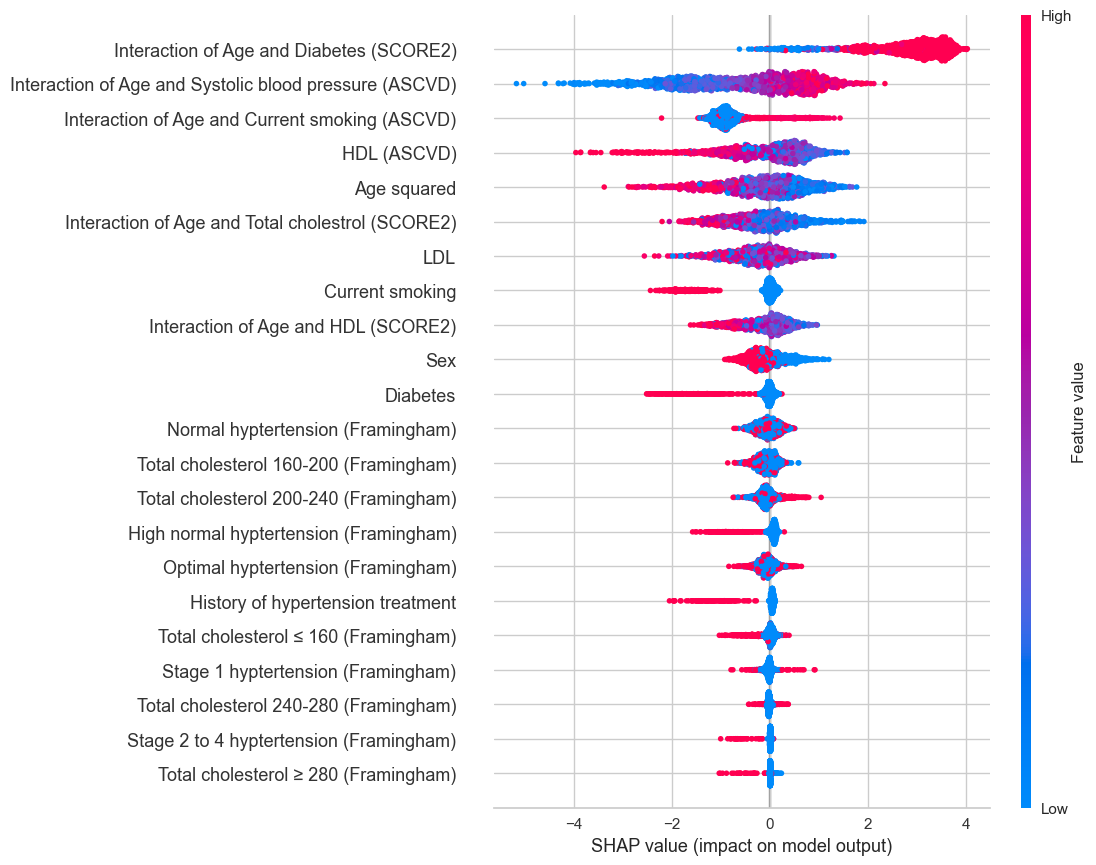

In [20]:
# Draw SHAP summary plot for patients without cardiovascular event

# Selecting patients without cardiovascular event
temp_test_normal = temp_test[temp_test['total_CVD_event'] == 0]
x_test_normal = temp_test_normal.drop(columns= ['total_CVD_event'])

# Calculating SHAP values
shap_values_normal_patients = explainer(x_test_normal)

# Draw plot
shap.plots.beeswarm(shap_values_normal_patients, max_display= 25, show= False)

# plt.savefig('Figure5_shap_normal_patients.jpg', dpi= 600, bbox_inches='tight')
plt.show()

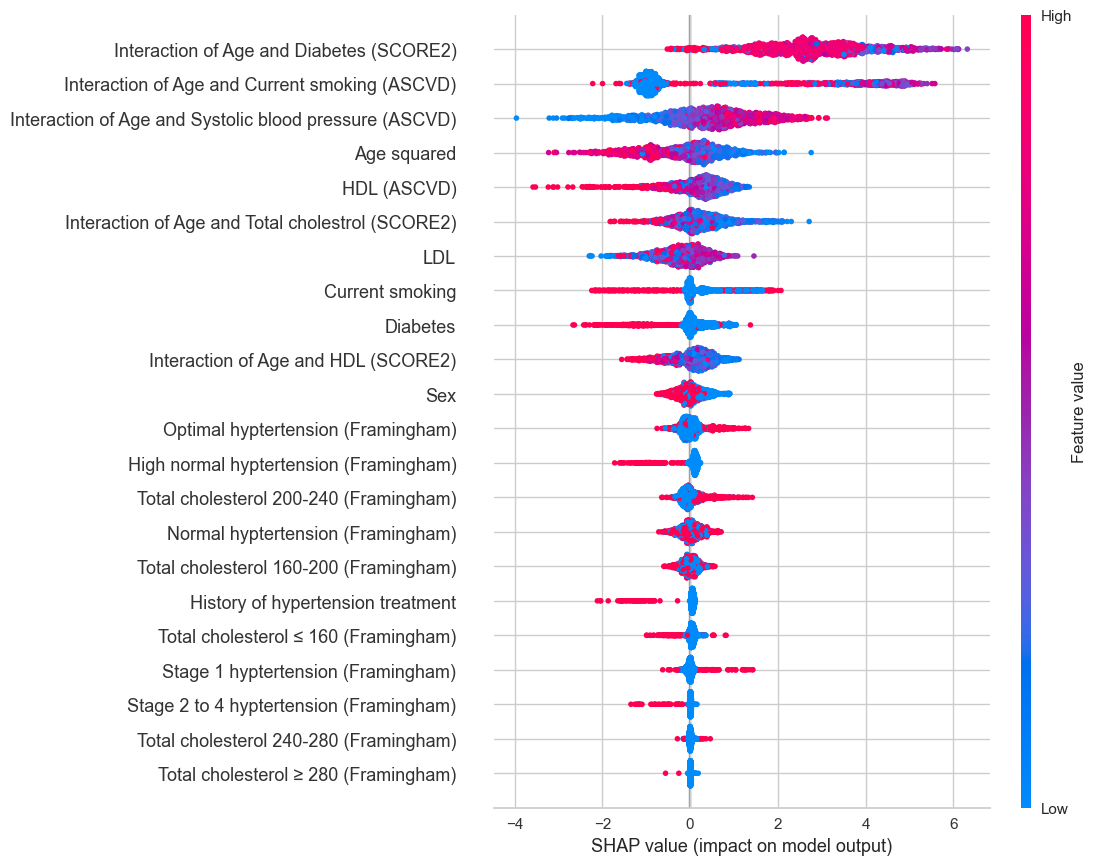

In [21]:
# Draw SHAP for patients with cardiovascular event

# Selecting patients with cardiovascular events
temp_test_event = temp_test[temp_test['total_CVD_event'] == 1]
x_test_event = temp_test_event.drop(columns= ['total_CVD_event'])

# Calculating SHAP values
shap_values_event_patients = explainer(x_test_event)

# Draw plot
shap.plots.beeswarm(shap_values_event_patients, max_display= 25, show= False)

# plt.savefig('Figure_shap_event_patients.jpg', dpi= 600, bbox_inches='tight')
plt.show()

## Save models information

In [92]:
save_model_information('Top features Catboost model', Top_features_catboost_model, x_test, y_test)

# Draw AUC curve figure

In [93]:
# Showing names of saved models
models_auc.keys()

dict_keys(['Basic Logistic Regression model', 'Basic Catboost model', 'ASCVD Logistic Regression model', 'Framingham Logistic Regression with Total cholesterol model', 'Framingham Logistic Regression with LDL model', 'SCORE2 Logistic Regression model', 'Comprehensive Catboost model', 'Top features Catboost model'])

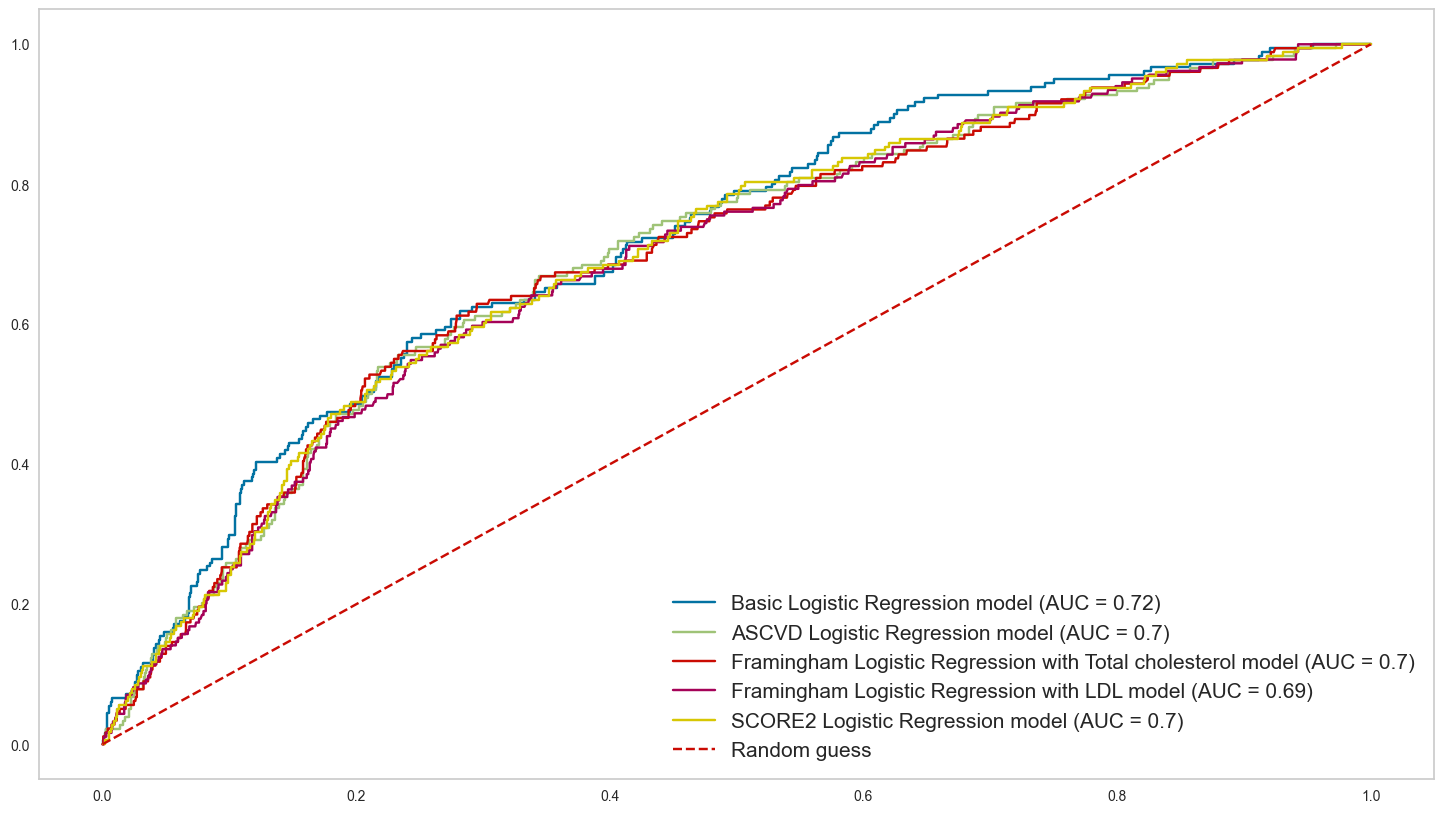

In [54]:
# Drawing AUC chart for logistic regression models
plt.figure(figsize=(18,10))

# List of models
models_list = ['Basic Logistic Regression model', 'ASCVD Logistic Regression model',
               'Framingham Logistic Regression with Total cholesterol model', 'Framingham Logistic Regression with LDL model',
               'SCORE2 Logistic Regression model']

# drawing auc for each model
for model in models_list:
    plt.plot(models_fpr.get(model), models_tpr.get(model), label=f'{model} (AUC = {models_auc.get(model)})')

# draw chance line
plt.plot([0,1], [0,1], 'r--', label='Random guess')

# showing chart
plt.legend(fontsize='15')
plt.grid(False)
# plt.title('Logistic Regression models_figure')
# plt.savefig('figure_logistic_regression_auc_chart.jpg', dpi= 600)
plt.show()

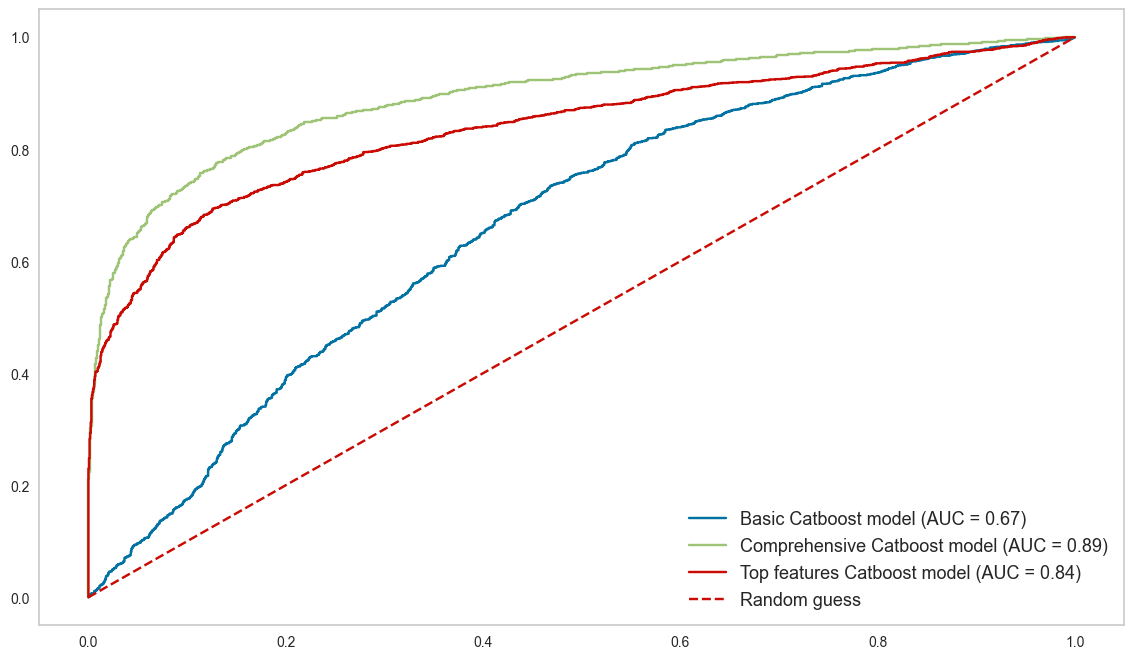

In [95]:
# Drawing AUC chart for CatBoost models
plt.figure(figsize=(14,8))

# List of models
models_list = ['Basic Catboost model', 'Comprehensive Catboost model','Top features Catboost model']

# drawing auc for each model
for model in models_list:
    plt.plot(models_fpr.get(model), models_tpr.get(model), label=f'{model} (AUC = {models_auc.get(model)})')

# draw chance line
plt.plot([0,1], [0,1], 'r--', label='Random guess')

# Showing chart
plt.legend(fontsize='13')
plt.grid(False)
# plt.title('Catboost models_figure3')
# plt.savefig('figure_catboost_auc_chart.jpg', dpi= 600)
plt.show()